# GLAM Stage I: GAM 기반 구조적 모델링

**논문**: GLAM: A Hybrid GAM-LSTM Framework for District Heat Demand Forecasting

이 노트북은 **Stage I (GAM)** 의 수학적 구성요소를 논문 수식에 맞게 구현합니다.

---

## 핵심 수식 개요

**Structural Component (Eq. 2)**:
$$L_t = \mu + g_{\text{trend}}(t) + f_{\text{heat}}(h_t) + f_{\text{cool}}(c_t) + S_{\text{season}}(\tau_t) + S_{\text{social}}(t)$$

구성요소:
1. $\mu$: Global intercept
2. $g_{\text{trend}}(t)$: Piecewise linear trend with changepoints (Eq. 8)
3. $f_{\text{heat}}(h_t)$: HDH 비선형 반응 - Penalized B-spline (Eq. 5)
4. $f_{\text{cool}}(c_t)$: CDH 비선형 반응 - Penalized B-spline (Eq. 6)
5. $S_{\text{season}}(\tau_t)$: Daily + Yearly Fourier terms (Eq. 10-12)
6. $S_{\text{social}}(t)$: Non-working day indicator (Eq. 13)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso

# GAM library
from pygam import LinearGAM, s, f, l
from pygam.terms import TermList

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully")


Libraries loaded successfully


---
## 1. 데이터 로드

In [33]:
# 강남 지점 데이터 로드
df = pd.read_csv('/Users/zongseung/Heat-Demand/CHP-project/whole-CHP-plant-data-ver2.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# 기본 정보
print(f"Data shape: {df.shape}")
print(f"Period: {df['date'].min()} ~ {df['date'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

##
# 이중에서 일단 강남만 본다 
df1 = df[df["branch"]=="광교"]

Data shape: (499301, 11)
Period: 2021-01-01 01:00:00 ~ 2023-12-31 23:00:00

Columns: ['date', 'branch', 'train_heat_ta_interp', 'heat_demand_imp', 'temperature_imp', 'season', 'is_weekend', 'is_holiday', 'is_offday', 'hdh', 'cdh']


---
## 2. Train / Validation / Test 분할

**중요**: 모든 Feature Engineering과 하이퍼파라미터 튜닝은 Train+Val 데이터만 사용

In [34]:
df1

,date,branch,train_heat_ta_interp,heat_demand_imp,temperature_imp,season,is_weekend,is_holiday,is_offday,hdh,cdh
15,2021-01-01 01:00:00,광교,-8.1,98.0,-8.1,Winter,0,1,1,26.1,0.0
31,2021-01-01 02:00:00,광교,-8.4,102.0,-8.4,Winter,0,1,1,26.4,0.0
51,2021-01-01 03:00:00,광교,-8.8,109.0,-8.8,Winter,0,1,1,26.8,0.0
63,2021-01-01 04:00:00,광교,-8.5,98.0,-8.5,Winter,0,1,1,26.5,0.0
87,2021-01-01 05:00:00,광교,-8.8,93.0,-8.8,Winter,0,1,1,26.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...
499215,2023-12-31 19:00:00,광교,2.3,96.0,2.3,Winter,1,0,1,15.7,0.0
499226,2023-12-31 20:00:00,광교,2.0,111.0,2.0,Winter,1,0,1,16.0,0.0
499258,2023-12-31 21:00:00,광교,1.1,101.0,1.1,Winter,1,0,1,16.9,0.0
499279,2023-12-31 22:00:00,광교,0.9,104.0,0.9,Winter,1,0,1,17.1,0.0


In [35]:
# Split ratio: 8 : 1 : 1
# Total = 10 (80% : 10% : 10%)

n = len(df1)

# 80% 지점
train_end = int(n * 0.8)

# 90% 지점 (80% + 10%)
val_end = int(n * 0.9)

print(f"Dataset Split (8:1:1):")
print(f"  Total: {n}")
print(f"  Train: 0 ~ {train_end} ({train_end} samples, {train_end/n*100:.1f}%)")
print(f"  Val:   {train_end} ~ {val_end} ({val_end - train_end} samples, {(val_end - train_end)/n*100:.1f}%)")
print(f"  Test:  {val_end} ~ {n} ({n - val_end} samples, {(n - val_end)/n*100:.1f}%)")

# Time index
df1['t'] = np.arange(len(df1))

Dataset Split (8:1:1):
  Total: 26279
  Train: 0 ~ 21023 (21023 samples, 80.0%)
  Val:   21023 ~ 23651 (2628 samples, 10.0%)
  Test:  23651 ~ 26279 (2628 samples, 10.0%)


---
## 3. Feature Engineering: 논문 수식 구현

### 3.1 HDH / CDH (Heating/Cooling Degree Hours)

**논문 Eq. (3), (4)**:
$$h_t := \max(0, T_{\text{base}} - T_t)$$
$$c_t := \max(0, T_t - T_{\text{base}})$$

여기서 $T_{\text{base}} = 18°C$

### 3.2 Fourier Terms for Multi-Seasonality

**논문 Eq. (10), (11), (12)**:

$$S_{\text{season}}(\tau_t) = S_{\text{daily}}(\tau_t) + S_{\text{yearly}}(\tau_t)$$

$$S_{\text{daily}}(\tau_t) = \sum_{k=1}^{K_d} \left[ a_{d,k} \cos\left(\frac{2\pi k \tau_t}{P_d}\right) + b_{d,k} \sin\left(\frac{2\pi k \tau_t}{P_d}\right) \right]$$

$$S_{\text{yearly}}(\tau_t) = \sum_{k=1}^{K_y} \left[ a_{y,k} \cos\left(\frac{2\pi k \tau_t}{P_y}\right) + b_{y,k} \sin\left(\frac{2\pi k \tau_t}{P_y}\right) \right]$$

여기서:
- $P_d = 24$ (일간 주기, 시간 단위)
- $P_y = 365.25 \times 24$ (연간 주기, 시간 단위)
- $K_d, K_y$: Fourier order (하이퍼파라미터)

In [36]:
def add_fourier_features(df: pd.DataFrame, 
                         datetime_col: str,
                         period_hours: float,
                         K: int,
                         prefix: str) -> pd.DataFrame:
    """
    Fourier terms 추가 - 논문 Eq. (11), (12)
    
    S(τ) = Σ [a_k cos(2πkτ/P) + b_k sin(2πkτ/P)]
    
    Args:
        df: DataFrame
        datetime_col: datetime 컬럼명
        period_hours: 주기 (시간 단위)
        K: Fourier order (하모닉 개수)
        prefix: 컬럼명 접두사 ('daily' or 'yearly')
    """
    # τ_t: 시작점으로부터의 시간 (hours)
    tau = (df[datetime_col] - df[datetime_col].iloc[0]).dt.total_seconds() / 3600
    
    for k in range(1, K + 1):
        # cos term: a_k * cos(2πkτ/P)
        df[f'{prefix}_cos_{k}'] = np.cos(2 * np.pi * k * tau / period_hours)
        # sin term: b_k * sin(2πkτ/P)
        df[f'{prefix}_sin_{k}'] = np.sin(2 * np.pi * k * tau / period_hours)
    
    return df


# 주기 정의
P_DAILY = 24              # 일간 주기 (시간)
P_YEARLY = 365.25 * 24    # 연간 주기 (시간)

print(f"Daily period: P_d = {P_DAILY} hours")
print(f"Yearly period: P_y = {P_YEARLY} hours")

Daily period: P_d = 24 hours
Yearly period: P_y = 8766.0 hours


### 3.3 Non-working Day Indicator (Social Cycles)

**논문 Eq. (13)**:

$$S_{\text{social}}(t) = \gamma_{\text{off}} \cdot I_{\text{off}}(t)$$

$$I_{\text{off}}(t) = \begin{cases} 1, & \text{if } t \text{ is weekend or public holiday} \\ 0, & \text{otherwise} \end{cases}$$

In [37]:
from workalendar.asia import SouthKorea

def create_nonworking_indicator(df: pd.DataFrame, datetime_col: str) -> pd.Series:
    """
    Non-working day indicator - 논문 Eq. (13)
    
    I_off(t) = 1 if weekend or public holiday, else 0
    """
    cal = SouthKorea()
    
    def is_non_working(dt):
        # workalendar의 is_working_day 메서드 사용
        return 0 if cal.is_working_day(dt) else 1
    
    return df[datetime_col].apply(is_non_working)


# 적용
df1['I_off'] = create_nonworking_indicator(df, 'date')

print(f"Non-working days (I_off=1): {df1['I_off'].sum()} / {len(df)} ({100*df1['I_off'].mean():.1f}%)")

# 샘플 공휴일 확인
cal = SouthKorea()
print(f"\n2023년 한국 공휴일 (일부):")
for h in cal.holidays(2023)[:5]:
    print(f"  {h[0]}: {h[1]}")

Non-working days (I_off=1): 8231 / 499301 (31.3%)

2023년 한국 공휴일 (일부):
  2023-01-01: New year
  2023-01-21: Korean New Year's Day
  2023-01-22: Korean New Year's Day
  2023-01-23: Korean New Year's Day
  2023-03-01: Independence Day


### 3.4 Piecewise Linear Trend with Changepoints

**논문 Eq. (8)**:

$$g_{\text{trend}}(t) = \beta_1 t + \sum_{j=1}^{K} \delta_j (t - c_j)_+$$

여기서:
- $(x)_+ = \max(0, x)$
- $\{c_1, ..., c_K\}$: changepoint 위치 (knots)
- $\delta_j$: changepoint $c_j$에서의 기울기 변화량

**논문 Eq. (9)** - L1 정규화로 sparse changepoints 유도:

$$\mathcal{P}_{cp}(\boldsymbol{\delta}) = \lambda_{cp} \sum_{j=1}^{K} |\delta_j|$$

In [38]:
def create_changepoint_features(df: pd.DataFrame,
                                 t_col: str,
                                 K: int,
                                 max_t: int) -> pd.DataFrame:
    """
    Changepoint features 생성 - 논문 Eq. (8)
    
    (t - c_j)_+ = max(0, t - c_j) for each changepoint c_j
    
    Args:
        df: DataFrame
        t_col: time index 컬럼명
        K: changepoint 개수
        max_t: changepoint 배치 범위 (data leakage 방지를 위해 train+val까지만)
    
    Returns:
        changepoint 위치 배열, 업데이트된 df
    """
    # K개의 changepoint를 균등 간격으로 배치
    changepoint_locs = np.linspace(0, max_t, K + 2)[1:-1].astype(int)
    
    for j, c_j in enumerate(changepoint_locs):
        # (t - c_j)_+ = max(0, t - c_j)
        df[f'cp_{j}'] = np.maximum(0, df[t_col] - c_j)
    
    return changepoint_locs, df


print("Changepoint features will be created after hyperparameter selection")

Changepoint features will be created after hyperparameter selection


### 3.5 Penalized B-Spline for Weather Response

**논문 Eq. (5), (6)**:

$$f_{\text{heat}}(h_t) = \sum_{m=1}^{M_h} \alpha_m B^{(h)}_{m,d}(h_t)$$

$$f_{\text{cool}}(c_t) = \sum_{n=1}^{M_c} \beta_n B^{(c)}_{n,d}(c_t)$$

**논문 Eq. (7)** - Smoothness penalty:

$$\mathcal{P}_{spl}(\boldsymbol{\alpha}, \boldsymbol{\beta}) = \lambda_h \|\mathbf{D}^{(2)}\boldsymbol{\alpha}\|_2^2 + \lambda_c \|\mathbf{D}^{(2)}\boldsymbol{\beta}\|_2^2$$

여기서 $\mathbf{D}^{(2)}$는 2차 차분 연산자

In [39]:
# B-Spline은 pyGAM의 s() term으로 구현됨
# s(feature_idx, n_splines=M) 형태로 사용
# smoothing parameter λ는 gridsearch로 튜닝

print("B-Spline weather response:")
print("  - pyGAM의 s(idx, n_splines=M) term 사용")
print("  - n_splines: basis function 개수 (하이퍼파라미터)")
print("  - λ (lam): smoothing penalty (gridsearch로 튜닝)")
print("  - 2차 차분 penalty가 자동 적용됨")

B-Spline weather response:
  - pyGAM의 s(idx, n_splines=M) term 사용
  - n_splines: basis function 개수 (하이퍼파라미터)
  - λ (lam): smoothing penalty (gridsearch로 튜닝)
  - 2차 차분 penalty가 자동 적용됨


---
## 4. Stage I 추정 목적함수

**논문 Eq. (14)**:

$$\min_{\Theta_{GAM}} \sum_{t \in \mathcal{T}_{tr}} (y_t - L_t)^2 + \lambda_h \|\mathbf{D}^{(2)}\boldsymbol{\alpha}\|_2^2 + \lambda_c \|\mathbf{D}^{(2)}\boldsymbol{\beta}\|_2^2 + \lambda_{cp} \mathcal{P}_{cp}(\boldsymbol{\delta})$$

구현 전략:
1. **GAM 부분**: pyGAM으로 trend, HDH/CDH spline, Fourier, social indicator 피팅
2. **Changepoint 부분**: Lasso regression으로 L1 정규화 적용

---
## 5. 하이퍼파라미터 Grid Search

튜닝 대상:
- $K_d$: Daily Fourier order
- $K_y$: Yearly Fourier order  
- $K_{cp}$: Changepoint 개수
- $n_{splines}$: HDH B-spline basis 개수
- $\lambda$: Smoothing parameter

In [40]:
from itertools import product

# Grid Search 설정
K_DAILY_CANDIDATES = [2, 3, 4, 5]
K_YEARLY_CANDIDATES = [5, 10, 15]
K_CP_CANDIDATES = [5, 10, 15, 20]
N_SPLINES_CANDIDATES = [10, 15, 20, 25]
ALPHA_CANDIDATES= [0.001, 0.01, 0.05, 0.1]

print("=== Hyperparameter Search Space ===")
print(f"  K_daily: {K_DAILY_CANDIDATES}")
print(f"  K_yearly: {K_YEARLY_CANDIDATES}")
print(f"  K_changepoints: {K_CP_CANDIDATES}")
print(f"  n_splines (HDH/CDH): {N_SPLINES_CANDIDATES}")
print(f"  alpha (Lasso): {ALPHA_CANDIDATES}")

total_combinations = (len(K_DAILY_CANDIDATES) * len(K_YEARLY_CANDIDATES) * len(K_CP_CANDIDATES) * len(N_SPLINES_CANDIDATES) * len(ALPHA_CANDIDATES))
print(f"\nTotal combinations: {total_combinations}")

=== Hyperparameter Search Space ===
  K_daily: [2, 3, 4, 5]
  K_yearly: [5, 10, 15]
  K_changepoints: [5, 10, 15, 20]
  n_splines (HDH/CDH): [10, 15, 20, 25]
  alpha (Lasso): [0.001, 0.01, 0.05, 0.1]

Total combinations: 768


In [41]:
def run_stage1_grid_search(df, train_end, val_end,
                           K_daily_list, K_yearly_list, K_cp_list, n_splines_list, alpha_list):
    """
    Stage I 하이퍼파라미터 Grid Search
    """
    results = []
    
    # [수정 1] product 안에 alpha_list를 반드시 포함시켜야 합니다.
    for K_d, K_y, K_cp, n_spl, alpha in product(K_daily_list, K_yearly_list, K_cp_list, n_splines_list, alpha_list):
        
        # 데이터 복사 및 초기화
        df_trial = df.copy()
        drop_cols = [c for c in df_trial.columns if c.startswith('daily_') or 
                     c.startswith('yearly_') or c.startswith('cp_')]
        df_trial = df_trial.drop(columns=drop_cols, errors='ignore')
        
        # 피처 생성
        df_trial = add_fourier_features(df_trial, 'date', P_DAILY, K_d, 'daily')
        df_trial = add_fourier_features(df_trial, 'date', P_YEARLY, K_y, 'yearly')
        
        # [중요 확인] Changepoint는 Train 기간 기준으로 생성 (Data Leakage 방지) -> 아주 잘하셨습니다!
        cp_locs, df_trial = create_changepoint_features(df_trial, 't', K_cp, train_end)
        
        # 컬럼 정의
        fourier_cols = [c for c in df_trial.columns if c.startswith('daily_') or c.startswith('yearly_')]
        cp_cols = [c for c in df_trial.columns if c.startswith('cp_')]
        gam_feature_cols = ['t', 'hdh', 'cdh', 'I_off'] + fourier_cols
        
        # GAM Terms
        idx_t = 0
        idx_hdh = 1
        idx_cdh = 2
        idx_ioff = 3
        
        gam_terms = (
            l(idx_t) +                       
            s(idx_hdh, n_splines=n_spl) +    
            s(idx_cdh, n_splines=n_spl) +    
            f(idx_ioff)                      
        )
        
        for i, col in enumerate(gam_feature_cols):
            if col.startswith('daily_') or col.startswith('yearly_'):
                gam_terms += l(i)
        
        # Train GAM
        X_train = df_trial.iloc[:train_end][gam_feature_cols].values
        y_train = df_trial.iloc[:train_end]['heat_demand_imp'].values
        
        gam = LinearGAM(gam_terms)
        gam.gridsearch(X_train, y_train, lam=np.logspace(-3, 3, 7), progress=False)
        
        # GAM Prediction
        X_tv = df_trial.iloc[:val_end][gam_feature_cols].values
        gam_pred_tv = gam.predict(X_tv)
        
        # Residual Calculation
        y_tv = df_trial.iloc[:val_end]['heat_demand_imp'].values
        residual_for_cp = y_tv - gam_pred_tv
        
        # [수정 2] Lasso 정의 시 alpha_list가 아니라 현재 루프의 'alpha' 값을 써야 합니다.
        X_cp_tv = df_trial.iloc[:val_end][cp_cols].values
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000) # <--- 여기 수정됨
        lasso.fit(X_cp_tv[:train_end], residual_for_cp[:train_end])
        
        # Prediction Sum
        cp_pred_tv = lasso.predict(X_cp_tv)
        L_hat_tv = gam_pred_tv + cp_pred_tv
        
        # Validation
        y_val = df_trial.iloc[train_end:val_end]['heat_demand_imp'].values
        L_hat_val = L_hat_tv[train_end:val_end]
        val_rmse = np.sqrt(mean_squared_error(y_val, L_hat_val))
        
        results.append({
            'K_daily': K_d,
            'K_yearly': K_y,
            'K_cp': K_cp,
            'n_splines': n_spl,
            'alpha': alpha,      # 기록
            'val_rmse': val_rmse,
            'n_features': len(gam_feature_cols) + len(cp_cols)
        })
        
        print(f"K_d={K_d}, K_y={K_y:2d}, K_cp={K_cp:2d}, n_spl={n_spl:2d}, alpha={alpha} | Val RMSE: {val_rmse:.4f}")
    
    return pd.DataFrame(results)

In [42]:
# Grid Search 실행
print("="*80)
print("Stage I Hyperparameter Grid Search")
print("="*80)

grid_results = run_stage1_grid_search(
    df1, train_end, val_end,
    K_DAILY_CANDIDATES, K_YEARLY_CANDIDATES, K_CP_CANDIDATES, N_SPLINES_CANDIDATES, ALPHA_CANDIDATES
)

# Best configuration
best_config = grid_results.loc[grid_results['val_rmse'].idxmin()]

print("\n" + "="*80)
print("Best Configuration:")
print(f"  K_daily:      {int(best_config['K_daily'])}")
print(f"  K_yearly:     {int(best_config['K_yearly'])}")
print(f"  K_cp:         {int(best_config['K_cp'])}")
print(f"  n_splines:    {int(best_config['n_splines'])}")
print(f"  Val RMSE:     {best_config['val_rmse']:.4f}")
print("="*80)

Stage I Hyperparameter Grid Search
K_d=2, K_y= 5, K_cp= 5, n_spl=10, alpha=0.001 | Val RMSE: 12.5786
K_d=2, K_y= 5, K_cp= 5, n_spl=10, alpha=0.01 | Val RMSE: 12.5787
K_d=2, K_y= 5, K_cp= 5, n_spl=10, alpha=0.05 | Val RMSE: 12.5789
K_d=2, K_y= 5, K_cp= 5, n_spl=10, alpha=0.1 | Val RMSE: 12.5792
K_d=2, K_y= 5, K_cp= 5, n_spl=15, alpha=0.001 | Val RMSE: 12.5583
K_d=2, K_y= 5, K_cp= 5, n_spl=15, alpha=0.01 | Val RMSE: 12.5583
K_d=2, K_y= 5, K_cp= 5, n_spl=15, alpha=0.05 | Val RMSE: 12.5586
K_d=2, K_y= 5, K_cp= 5, n_spl=15, alpha=0.1 | Val RMSE: 12.5589
K_d=2, K_y= 5, K_cp= 5, n_spl=20, alpha=0.001 | Val RMSE: 12.5532
K_d=2, K_y= 5, K_cp= 5, n_spl=20, alpha=0.01 | Val RMSE: 12.5533
K_d=2, K_y= 5, K_cp= 5, n_spl=20, alpha=0.05 | Val RMSE: 12.5535
K_d=2, K_y= 5, K_cp= 5, n_spl=20, alpha=0.1 | Val RMSE: 12.5538
K_d=2, K_y= 5, K_cp= 5, n_spl=25, alpha=0.001 | Val RMSE: 12.5369
K_d=2, K_y= 5, K_cp= 5, n_spl=25, alpha=0.01 | Val RMSE: 12.5370
K_d=2, K_y= 5, K_cp= 5, n_spl=25, alpha=0.05 | Val RMS

---
## 6. 최적 하이퍼파라미터로 Stage I 모델 학습

In [43]:
# 최적 하이퍼파라미터 적용
K_DAILY_OPT = int(best_config['K_daily'])
K_YEARLY_OPT = int(best_config['K_yearly'])
K_CP_OPT = int(best_config['K_cp'])
N_SPLINES_OPT = int(best_config['n_splines'])
N_alpha_OPT = int(best_config['alpha'])

print(f"Optimal hyperparameters:")
print(f"  K_daily = {K_DAILY_OPT}")
print(f"  K_yearly = {K_YEARLY_OPT}")
print(f"  K_changepoints = {K_CP_OPT}")
print(f"  n_splines = {N_SPLINES_OPT}")
print(f"  alpha = {N_alpha_OPT}")

Optimal hyperparameters:
  K_daily = 5
  K_yearly = 5
  K_changepoints = 5
  n_splines = 25
  alpha = 0


In [44]:
# 기존 Fourier/Changepoint 컬럼 제거
drop_cols = [c for c in df1.columns if c.startswith('daily_') or 
             c.startswith('yearly_') or c.startswith('cp_')]
df1 = df1.drop(columns=drop_cols, errors='ignore')

# Fourier features 추가 (최적 K값) - Eq. (11), (12)
df1 = add_fourier_features(df1, 'date', P_DAILY, K_DAILY_OPT, 'daily')
df1 = add_fourier_features(df1, 'date', P_YEARLY, K_YEARLY_OPT, 'yearly')

# Changepoint features 추가 (train+val 범위만) - Eq. (8)
CP_LOCS, df1 = create_changepoint_features(df1, 't', K_CP_OPT, val_end)

print(f"Changepoint locations: {CP_LOCS}")

# Feature columns
FOURIER_COLS = [c for c in df1.columns if c.startswith('daily_') or c.startswith('yearly_')]
CP_COLS = [c for c in df1.columns if c.startswith('cp_')]

# GAM features: t, hdh, cdh, I_off + Fourier (논문 Eq. 2 전체)
GAM_FEATURE_COLS = ['t', 'hdh', 'cdh', 'I_off'] + FOURIER_COLS

print(f"\nFeature columns (논문 Eq. 2):")
print(f"  GAM features: {len(GAM_FEATURE_COLS)}")
print(f"    - Trend: t (β₁t)")
print(f"    - Weather: hdh (Eq.5 f_heat), cdh (Eq.6 f_cool)")
print(f"    - Social: I_off (Eq.13)")
print(f"    - Fourier: {len(FOURIER_COLS)} terms (Eq.11 daily, Eq.12 yearly)")
print(f"  Changepoint features: {len(CP_COLS)} (Eq.8)")
print(f"  Total: {len(GAM_FEATURE_COLS) + len(CP_COLS)}")

Changepoint locations: [ 3941  7883 11825 15767 19709]

Feature columns (논문 Eq. 2):
  GAM features: 24
    - Trend: t (β₁t)
    - Weather: hdh (Eq.5 f_heat), cdh (Eq.6 f_cool)
    - Social: I_off (Eq.13)
    - Fourier: 20 terms (Eq.11 daily, Eq.12 yearly)
  Changepoint features: 5 (Eq.8)
  Total: 29


In [45]:
# GAM 모델 정의 (논문 Eq. 2 전체 구조)
# L_t = μ + g_trend(t) + f_heat(h_t) + f_cool(c_t) + S_season(τ_t) + S_social(t)

idx_t = GAM_FEATURE_COLS.index('t')
idx_hdh = GAM_FEATURE_COLS.index('hdh')
idx_cdh = GAM_FEATURE_COLS.index('cdh')
idx_ioff = GAM_FEATURE_COLS.index('I_off')

gam_terms = (
    l(idx_t) +                              # Linear trend: g_trend(t) = β₁t
    s(idx_hdh, n_splines=N_SPLINES_OPT) +   # B-spline for HDH: f_heat(h_t) (Eq. 5)
    s(idx_cdh, n_splines=N_SPLINES_OPT) +   # B-spline for CDH: f_cool(c_t) (Eq. 6) *** 논문대로 추가 ***
    f(idx_ioff)                             # Categorical: S_social(t) = γ_off * I_off(t) (Eq. 13)
)

# Fourier terms (Eq. 11, 12) - S_season(τ_t)
for i, col in enumerate(GAM_FEATURE_COLS):
    if col.startswith('daily_') or col.startswith('yearly_'):
        gam_terms += l(i)

print("="*60)
print("GAM model structure (논문 Eq. 2):")
print("="*60)
print("  L_t = μ + g_trend(t) + f_heat(h_t) + f_cool(c_t) + S_season(τ_t) + S_social(t)")
print("\nComponents:")
print(f"  - l(t): Linear trend g_trend(t) = β₁t")
print(f"  - s(hdh, n_splines={N_SPLINES_OPT}): f_heat(h_t) - HDH B-spline (Eq. 5)")
print(f"  - s(cdh, n_splines={N_SPLINES_OPT}): f_cool(c_t) - CDH B-spline (Eq. 6)")
print(f"  - f(I_off): S_social(t) = γ_off · I_off(t) (Eq. 13)")
print(f"  - l(Fourier): {len(FOURIER_COLS)} terms for S_season(τ_t) (Eq. 11, 12)")

GAM model structure (논문 Eq. 2):
  L_t = μ + g_trend(t) + f_heat(h_t) + f_cool(c_t) + S_season(τ_t) + S_social(t)

Components:
  - l(t): Linear trend g_trend(t) = β₁t
  - s(hdh, n_splines=25): f_heat(h_t) - HDH B-spline (Eq. 5)
  - s(cdh, n_splines=25): f_cool(c_t) - CDH B-spline (Eq. 6)
  - f(I_off): S_social(t) = γ_off · I_off(t) (Eq. 13)
  - l(Fourier): 20 terms for S_season(τ_t) (Eq. 11, 12)


In [46]:
# Train+Val 데이터로 GAM 학습
X_trainval = df1.iloc[:val_end][GAM_FEATURE_COLS].values
y_trainval = df1.iloc[:val_end]['heat_demand_imp'].values

gam_model = LinearGAM(gam_terms)
gam_model.gridsearch(X_trainval, y_trainval, lam=np.logspace(-3, 3, 11))

print(f"GAM fitted with λ = {gam_model.lam}")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


GAM fitted with λ = [[np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)], [np.float64(63.0957344480193)]]


In [47]:
# -------------------------------------------------------
# Stage I Final Fit: 최적 파라미터로 최종 모델 학습
# -------------------------------------------------------

# 1. 최적 하이퍼파라미터 가져오기
best_K_d = int(best_config['K_daily'])
best_K_y = int(best_config['K_yearly'])
best_K_cp = int(best_config['K_cp'])
best_n_spl = int(best_config['n_splines'])
best_alpha = best_config['alpha']

print(f"Refitting Stage I with Best Params: K_d={best_K_d}, K_y={best_K_y}, K_cp={best_K_cp}, n_spl={best_n_spl}, alpha={best_alpha}")

# 2. 피처 다시 생성 (최적의 K값 적용)
# 기존 임시 컬럼 제거
cols_to_drop = [c for c in df1.columns if c.startswith('daily_') or c.startswith('yearly_') or c.startswith('cp_')]
df1 = df1.drop(columns=cols_to_drop, errors='ignore')

# 최적화된 K값으로 피처 재생성
df1 = add_fourier_features(df1, 'date', P_DAILY, best_K_d, 'daily')
df1 = add_fourier_features(df1, 'date', P_YEARLY, best_K_y, 'yearly')

# Changepoint 후보 생성 (Train 기간 기준)
cp_locs, df1 = create_changepoint_features(df1, 't', best_K_cp, train_end) 

# 컬럼 리스트 갱신
fourier_cols = [c for c in df1.columns if c.startswith('daily_') or c.startswith('yearly_')]
cp_cols = [c for c in df1.columns if c.startswith('cp_')]
gam_feature_cols = ['t', 'hdh', 'cdh', 'I_off'] + fourier_cols

# 3. GAM 재학습 (Train+Val 전체 데이터 사용)
# GAM Terms 재정의 (최적 n_splines 적용)
gam_terms = (
    l(0) +                           # t
    s(1, n_splines=best_n_spl) +     # hdh
    s(2, n_splines=best_n_spl) +     # cdh
    f(3)                             # I_off
)
for i in range(len(fourier_cols)):
    gam_terms += l(i + 4)            # Fourier terms

# Train+Val 데이터 준비
X_trainval = df1.iloc[:val_end][gam_feature_cols].values
y_trainval = df1.iloc[:val_end]['heat_demand_imp'].values

# GAM 학습 (lam 최적화 포함)
gam_final = LinearGAM(gam_terms)
gam_final.gridsearch(X_trainval, y_trainval, lam=np.logspace(-3, 3, 5), progress=False)

# GAM 예측
gam_pred_trainval = gam_final.predict(X_trainval)

# 4. Lasso 재학습 (Residual에 대해, 최적 Alpha 적용)
residual_for_cp = y_trainval - gam_pred_trainval
X_cp_trainval = df1.iloc[:val_end][cp_cols].values

# [수정 포인트] 최적의 alpha 적용!
lasso_final = Lasso(alpha=best_alpha, fit_intercept=False, max_iter=10000)
lasso_final.fit(X_cp_trainval, residual_for_cp)

# 5. 결과 확인
n_active_cp = np.sum(np.abs(lasso_final.coef_) > 1e-6)
print(f"Final Model Trained.")
print(f"  - Active Changepoints: {n_active_cp} / {len(cp_locs)}")
print(f"  - Lasso Alpha Used: {best_alpha}")

# 6. 전체 예측값 저장 (Stage II를 위해 잔차 계산용)
# L_hat = GAM_pred + Changepoint_pred
cp_pred_all = lasso_final.predict(df1[cp_cols].values)
gam_pred_all = gam_final.predict(df1[gam_feature_cols].values)

df1['L_hat'] = gam_pred_all + cp_pred_all
df1['residual'] = df1['heat_demand_imp'] - df1['L_hat']

print("\nSaved 'L_hat' and 'residual' columns to dataframe.")
print(df1[['date', 'heat_demand_imp', 'L_hat', 'residual']].head())

Refitting Stage I with Best Params: K_d=5, K_y=5, K_cp=5, n_spl=25, alpha=0.001
Final Model Trained.
  - Active Changepoints: 5 / 5
  - Lasso Alpha Used: 0.001

Saved 'L_hat' and 'residual' columns to dataframe.
                  date  heat_demand_imp       L_hat  residual
15 2021-01-01 01:00:00             98.0  103.252311 -5.252311
31 2021-01-01 02:00:00            102.0  100.590718  1.409282
51 2021-01-01 03:00:00            109.0   99.434972  9.565028
63 2021-01-01 04:00:00             98.0   96.918525  1.081475
87 2021-01-01 05:00:00             93.0   96.737237 -3.737237


Applying best hyperparameters...
Refitting Stage I model (GAM + Lasso)...
Stage I Refit Complete.
Saved 'L_hat' and 'residual'.
Decomposing components...
Decomposition DataFrame created.
                  date  Total_L_hat  Trend_Linear  Trend_Changepoint  \
15 2021-01-01 01:00:00   103.252311      0.000000                0.0   
31 2021-01-01 02:00:00   100.590718      0.000079                0.0   
51 2021-01-01 03:00:00    99.434972      0.000157                0.0   
63 2021-01-01 04:00:00    96.918525      0.000236                0.0   
87 2021-01-01 05:00:00    96.737237      0.000315                0.0   

    Trend_Total  Effect_HDH  Effect_CDH  Effect_Seasonality  Effect_Holiday  \
15     0.000000   23.971443  -22.776215           13.751823       -1.819757   
31     0.000079   24.821994  -22.776215           10.239601       -1.819757   
51     0.000157   25.975637  -22.776215            7.930133       -1.819757   
63     0.000236   25.108475  -22.776215            6.280770     

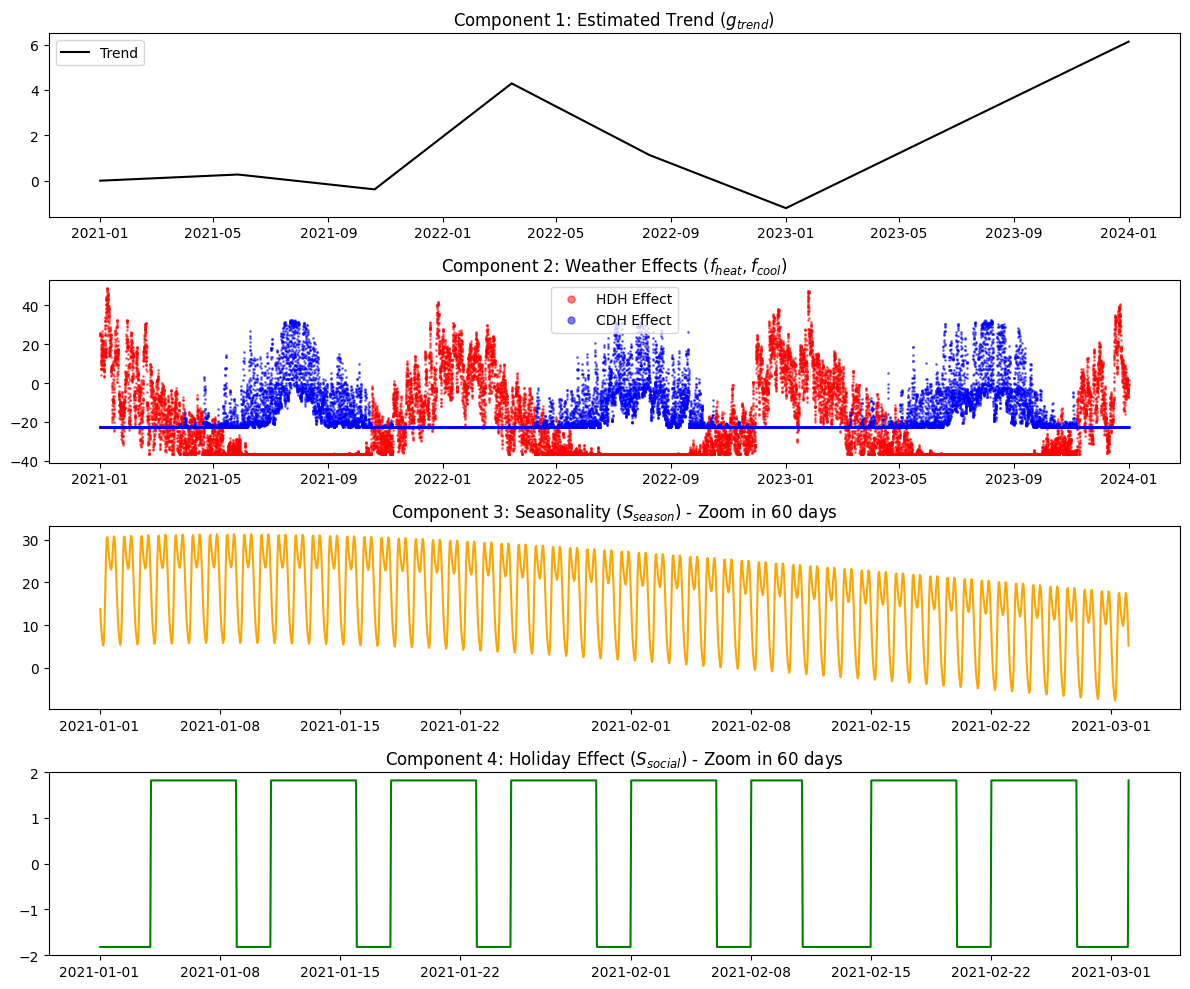

1. Relative Feature Importance (Based on Variance)
                    Std_Dev (MW)  Importance (%)
Effect_HDH                 18.87           40.04
Effect_Seasonality         13.36           28.35
Effect_CDH                 11.38           24.15
Trend_Total                 1.82            3.87
Effect_Holiday              1.69            3.58

[해석 Tip] 특정 요인의 표준편차가 클수록, MW 단위의 수요 변화를 많이 유발한다는 뜻입니다.

2. Quantitative Insights (본문 서술용 수치)
Average Reduction on Non-working Days: -3.64 MW
  (Workday Avg: 1.82, Holiday Avg: -1.82)
Max Heating Demand Increase due to Cold (HDH): +48.94 MW
Daily/Yearly Seasonality Fluctuation Range: 58.94 MW

3. Model Statistical Summary (P-values)
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.165

In [48]:

# [전제] best_config는 이전 Grid Search 결과에서 가져왔다고 가정
# 만약 alpha가 grid search에 없었다면 기본값 설정 필요
if 'alpha' not in best_config:
    best_config['alpha'] = 0.01  # Lasso 기본값

# -------------------------------------------------------
# 1. Feature Re-generation (최적 파라미터 적용)
# -------------------------------------------------------
print("Applying best hyperparameters...")
best_K_d = int(best_config['K_daily'])
best_K_y = int(best_config['K_yearly'])
best_K_cp = int(best_config['K_cp'])
best_n_spl = int(best_config['n_splines'])
best_alpha = best_config['alpha']

# 기존 임시 컬럼 제거 (충돌 방지)
cols_to_drop = [c for c in df1.columns if c.startswith('daily_') or 
                c.startswith('yearly_') or c.startswith('cp_')]
df1 = df1.drop(columns=cols_to_drop, errors='ignore')

# 최적 K값으로 Fourier Feature 생성
df1 = add_fourier_features(df1, 'date', P_DAILY, best_K_d, 'daily')
df1 = add_fourier_features(df1, 'date', P_YEARLY, best_K_y, 'yearly')

# 최적 K값으로 Changepoint Feature 생성 (Train 기간 기준 배치)
cp_locs, df1 = create_changepoint_features(df1, 't', best_K_cp, train_end)

# 컬럼 리스트 업데이트
fourier_cols = [c for c in df1.columns if c.startswith('daily_') or c.startswith('yearly_')]
cp_cols = [c for c in df1.columns if c.startswith('cp_')]
gam_feature_cols = ['t', 'hdh', 'cdh', 'I_off'] + fourier_cols

# -------------------------------------------------------
# 2. Stage I Final Fit (재학습)
# -------------------------------------------------------
print("Refitting Stage I model (GAM + Lasso)...")

# GAM Terms 재정의
gam_terms = (
    l(0) +                           # t (Trend)
    s(1, n_splines=best_n_spl) +     # hdh
    s(2, n_splines=best_n_spl) +     # cdh
    f(3)                             # I_off
)
for i in range(len(fourier_cols)):
    gam_terms += l(i + 4)            # Fourier terms

# Train+Val 데이터 준비
X_trainval = df1.iloc[:val_end][gam_feature_cols].values
y_trainval = df1.iloc[:val_end]['heat_demand_imp'].values

# (1) GAM 재학습 (gam_final)
gam_final = LinearGAM(gam_terms)
gam_final.gridsearch(X_trainval, y_trainval, lam=np.logspace(-3, 3, 5), progress=False)

# (2) Lasso 재학습 (잔차에 대해)
gam_pred_trainval = gam_final.predict(X_trainval)
residual_for_cp = y_trainval - gam_pred_trainval

X_cp_trainval = df1.iloc[:val_end][cp_cols].values
lasso_final = Lasso(alpha=best_alpha, fit_intercept=False, max_iter=10000)
lasso_final.fit(X_cp_trainval, residual_for_cp)

print("Stage I Refit Complete.")

# -------------------------------------------------------
# 3. Global Prediction & Residual Calculation
# -------------------------------------------------------
# 전체 데이터에 대한 예측 (X_all 정의 필수!)
X_all = df1[gam_feature_cols].values
X_cp_all = df1[cp_cols].values

# 예측 수행
gam_pred_all = gam_final.predict(X_all)
cp_pred_all = lasso_final.predict(X_cp_all)

# 결과 저장
df1['L_hat'] = gam_pred_all + cp_pred_all
df1['residual'] = df1['heat_demand_imp'] - df1['L_hat']

print("Saved 'L_hat' and 'residual'.")

# =========================================================
# 4. Decomposition (수정됨: Intercept 에러 방지 포함)
# =========================================================
print("Decomposing components...")

# 인덱스 정의
term_idx_trend = 0
term_idx_hdh = 1
term_idx_cdh = 2
term_idx_ioff = 3
n_basic_terms = 4
# Fourier term 인덱스 범위 설정
fourier_term_indices = range(n_basic_terms, len(gam_final.terms))

# (1) Base Trend
contrib_trend_linear = gam_final.partial_dependence(term=term_idx_trend, X=X_all)

# (2) Weather Effects
contrib_hdh = gam_final.partial_dependence(term=term_idx_hdh, X=X_all)
contrib_cdh = gam_final.partial_dependence(term=term_idx_cdh, X=X_all)

# (3) Social Effect
contrib_ioff = gam_final.partial_dependence(term=term_idx_ioff, X=X_all)

# (4) Seasonality (Fourier 합산) - [수정된 부분]
contrib_seasonality = np.zeros(len(df1))
for i in fourier_term_indices:
    # 만약 해당 항이 Intercept(절편)라면 계산하지 않고 건너뜀
    if gam_final.terms[i].isintercept:
        continue
    contrib_seasonality += gam_final.partial_dependence(term=i, X=X_all).flatten()

# (5) Changepoints (Lasso 결과)
contrib_changepoint = cp_pred_all

# (6) Intercept
intercept = gam_final.coef_[-1]

# DataFrame 생성
df_components = pd.DataFrame({
    'date': df1['date'],
    'Total_L_hat': df1['L_hat'],
    'Trend_Linear': contrib_trend_linear,
    'Trend_Changepoint': contrib_changepoint,
    'Trend_Total': contrib_trend_linear + contrib_changepoint, # g_trend(t)
    'Effect_HDH': contrib_hdh,
    'Effect_CDH': contrib_cdh,
    'Effect_Seasonality': contrib_seasonality,
    'Effect_Holiday': contrib_ioff,
    'Intercept': intercept
})

print("Decomposition DataFrame created.")
print(df_components.head())

# =========================================================
# 5. Visualization (논문 4.2.1)
# =========================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# 1. Trend
plt.subplot(4, 1, 1)
plt.plot(df_components['date'], df_components['Trend_Total'], color='k', label='Trend')
plt.title('Component 1: Estimated Trend ($g_{trend}$)')
plt.legend()

# 2. Weather
plt.subplot(4, 1, 2)
# 데이터가 많으므로 점 크기(s)를 줄이고 투명도(alpha)를 줘서 밀집도 표현
plt.scatter(df_components['date'], df_components['Effect_HDH'], s=1, c='r', alpha=0.5, label='HDH Effect')
plt.scatter(df_components['date'], df_components['Effect_CDH'], s=1, c='b', alpha=0.5, label='CDH Effect')
plt.title('Component 2: Weather Effects ($f_{heat}, f_{cool}$)')
plt.legend(markerscale=5) # 범례 아이콘 크기 키움

# 3. Seasonality (일부 구간 확대 - 예: 첫 2달)
plt.subplot(4, 1, 3)
zoom_slice = slice(0, 24*60) # 약 2달치
plt.plot(df_components['date'][zoom_slice], df_components['Effect_Seasonality'][zoom_slice], color='orange')
plt.title('Component 3: Seasonality ($S_{season}$) - Zoom in 60 days')

# 4. Holiday
plt.subplot(4, 1, 4)
plt.plot(df_components['date'][zoom_slice], df_components['Effect_Holiday'][zoom_slice], color='green')
plt.title('Component 4: Holiday Effect ($S_{social}$) - Zoom in 60 days')

plt.tight_layout()
plt.show()

# =========================================================
# 6. Numerical Analysis (단위 수정: MW)
# =========================================================
# 단위 설정
unit_label = "MW"

print("="*50)
print("1. Relative Feature Importance (Based on Variance)")
print("="*50)

# (1) 각 성분별 표준편차 계산 (변동성 크기 = 영향력)
stats_df = df_components.drop(columns=['date', 'Total_L_hat', 'Intercept', 'Trend_Linear', 'Trend_Changepoint'])
std_values = stats_df.std()

# (2) 전체 합 대비 비율 (%)
importance_percent = (std_values / std_values.sum()) * 100
importance_df = pd.DataFrame({
    f'Std_Dev ({unit_label})': std_values,
    'Importance (%)': importance_percent
}).sort_values('Importance (%)', ascending=False)

print(importance_df.round(2))
print(f"\n[해석 Tip] 특정 요인의 표준편차가 클수록, {unit_label} 단위의 수요 변화를 많이 유발한다는 뜻입니다.")


print("\n" + "="*50)
print("2. Quantitative Insights (본문 서술용 수치)")
print("="*50)

# (1) 휴일 효과 (Non-working day Effect)
# I_off가 1인 날들의 Effect_Holiday 평균값 vs 0인 날들의 평균값 차이
avg_holiday_effect = df_components.loc[df1['I_off'] == 1, 'Effect_Holiday'].mean()
avg_workday_effect = df_components.loc[df1['I_off'] == 0, 'Effect_Holiday'].mean()
diff_holiday = avg_holiday_effect - avg_workday_effect

print(f"Average Reduction on Non-working Days: {diff_holiday:.2f} {unit_label}")
print(f"  (Workday Avg: {avg_workday_effect:.2f}, Holiday Avg: {avg_holiday_effect:.2f})")

# (2) 날씨 민감도 (Max Weather Impact)
max_hdh_impact = df_components['Effect_HDH'].max()
print(f"Max Heating Demand Increase due to Cold (HDH): +{max_hdh_impact:.2f} {unit_label}")

# (3) 계절성 변동폭 (Seasonality Range)
# 해석: 시간/계절 요인만으로 수요가 최대 바닥에서 꼭대기까지 몇 MW나 오르내리는지
seasonality_range = df_components['Effect_Seasonality'].max() - df_components['Effect_Seasonality'].min()
print(f"Daily/Yearly Seasonality Fluctuation Range: {seasonality_range:.2f} {unit_label}")


print("\n" + "="*50)
print("3. Model Statistical Summary (P-values)")
print("="*50)
try:
    print(gam_final.summary())
except Exception as e:
    print("Summary generation skipped due to display constraints.")

---
## 7. Stage I 결과 평가

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_metrics(y_true, y_pred, name):
    """평가 메트릭 계산 및 출력"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # MAPE: 0으로 나누는 것 방지 (epsilon 추가)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n[{name}]")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}


# -------------------------------------------------------
# Stage I 평가 실행
# -------------------------------------------------------
print("="*60)
print("Stage I (GAM + Changepoint) Performance Analysis")
print("="*60)

# [중요] 앞선 단계에서 계산하여 df1에 저장해둔 'L_hat'을 가져옵니다.
L_hat_all = df1['L_hat'].values
y_true_all = df1['heat_demand_imp'].values

# 1. Train Evaluation
metrics_train = evaluate_metrics(
    y_true_all[:train_end],
    L_hat_all[:train_end],
    "Train"
)

# 2. Validation Evaluation
metrics_val = evaluate_metrics(
    y_true_all[train_end:val_end],
    L_hat_all[train_end:val_end],
    "Validation"
)

# 3. Test Evaluation (참고용)
# Stage II(LSTM)까지 합쳐야 진짜 최종 성능이 나오지만, 
# 구조적 모델(Stage I)만으로도 어느 정도 맞추는지 확인하는 용도입니다.
metrics_test = evaluate_metrics(
    y_true_all[val_end:],
    L_hat_all[val_end:],
    "Test"
)

print("\n" + "="*60)
print("NOTE: Stage I Residuals will now be fed into Stage II (LSTM).")
print("="*60)

Stage I (GAM + Changepoint) Performance Analysis

[Train]
  MSE:  109.9115
  RMSE: 10.4839
  MAE:  8.0607
  MAPE: 8235581.22%
  R²:   0.8767

[Validation]
  MSE:  123.6742
  RMSE: 11.1209
  MAE:  8.5996
  MAPE: 19.42%
  R²:   0.7684

[Test]
  MSE:  116.0729
  RMSE: 10.7737
  MAE:  8.5486
  MAPE: 24.04%
  R²:   0.8791

NOTE: Stage I Residuals will now be fed into Stage II (LSTM).


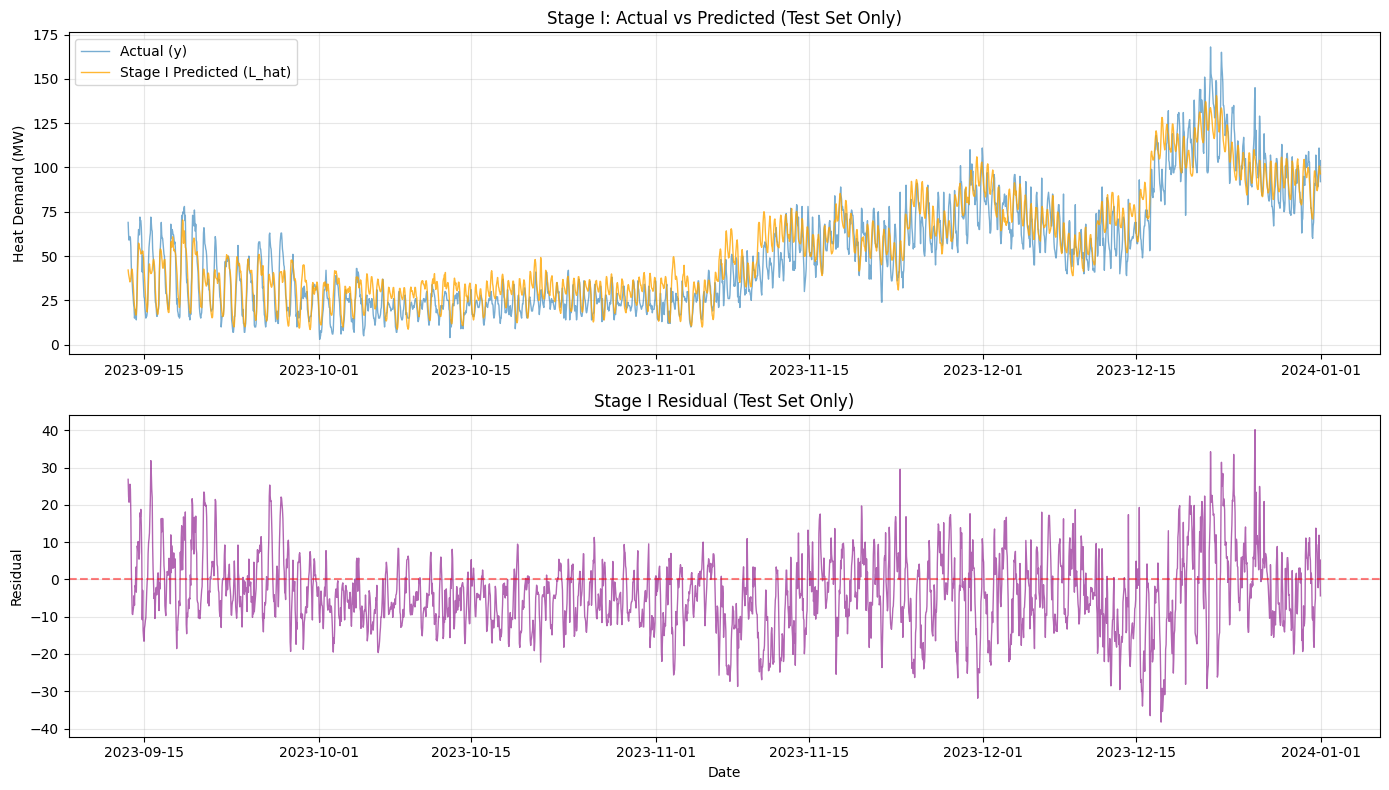

In [50]:
# Test Set 구간 슬라이싱 (val_end 부터 끝까지)
test_slice = slice(val_end, None)

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 1. y vs L_hat (Test Set Only)
axes[0].plot(df1['date'][test_slice], df1['heat_demand_imp'][test_slice], 
             label='Actual (y)', alpha=0.6, linewidth=1.0)
axes[0].plot(df1['date'][test_slice], L_hat_all[test_slice], 
             label='Stage I Predicted (L_hat)', alpha=0.8, linewidth=1.0, color='orange')

axes[0].set_title('Stage I: Actual vs Predicted (Test Set Only)')
axes[0].set_ylabel('Heat Demand (MW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residual (Test Set Only)
axes[1].plot(df1['date'][test_slice], df1['residual'][test_slice], 
             alpha=0.6, linewidth=1.0, color='purple')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)

axes[1].set_title('Stage I Residual (Test Set Only)')
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 8. GAM 컴포넌트별 분해 시각화

각 구성요소의 기여도 확인:
- Trend: $g_{\text{trend}}(t)$
- Weather: $f_{\text{heat}}(h_t)$
- Social: $S_{\text{social}}(t) = \gamma_{\text{off}} I_{\text{off}}(t)$
- Season: $S_{\text{season}}(\tau_t)$ (Fourier)

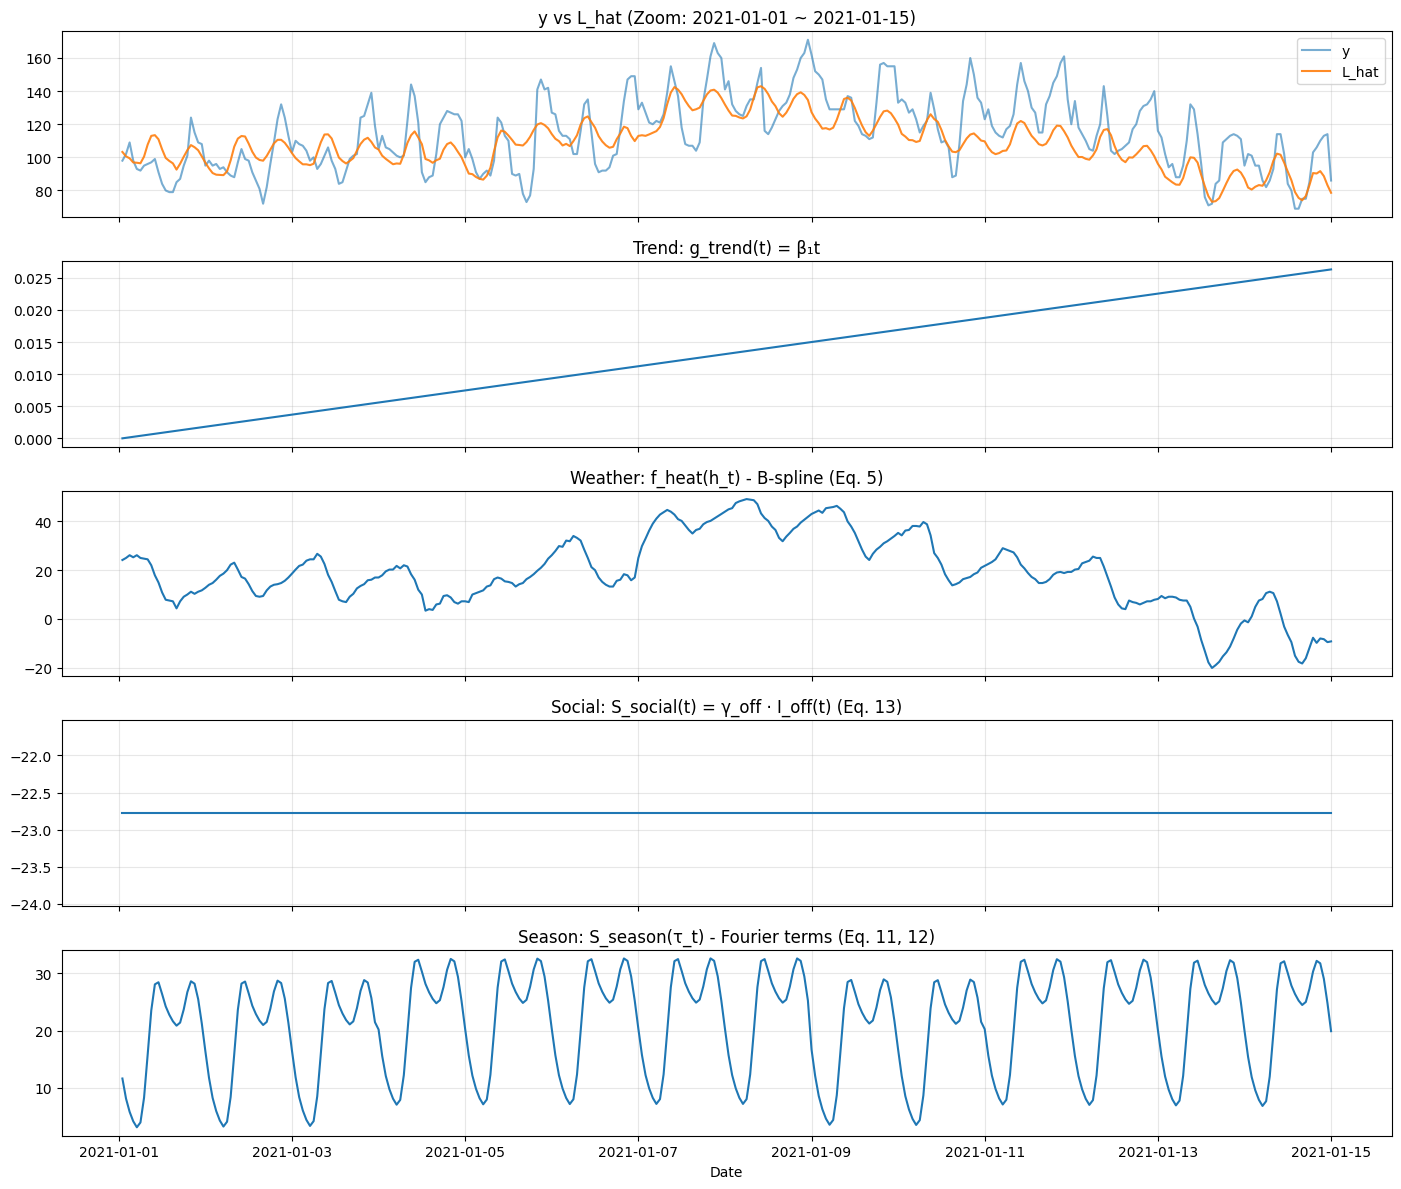

In [51]:
# 14일 구간 확대 시각화
start_dt = df1['date'].iloc[0]
end_dt = start_dt + pd.Timedelta(days=14)
mask = (df1['date'] >= start_dt) & (df1['date'] < end_dt)

x = df1.loc[mask, 'date']
X_zoom = df1.loc[mask, GAM_FEATURE_COLS].values

# 각 컴포넌트의 partial dependence
trend_contrib = gam_model.partial_dependence(term=0, X=X_zoom)   # l(t)
weather_contrib = gam_model.partial_dependence(term=1, X=X_zoom)  # s(HDH)
social_contrib = gam_model.partial_dependence(term=2, X=X_zoom)   # f(I_off)

# Fourier terms 합산
fourier_term_indices = [i for i, col in enumerate(GAM_FEATURE_COLS) 
                        if col.startswith('daily_') or col.startswith('yearly_')]
season_contrib = sum(gam_model.partial_dependence(term=i+3, X=X_zoom) 
                     for i in range(len(fourier_term_indices)))

fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

# y vs L_hat (zoom)
axes[0].plot(x, df1.loc[mask, 'heat_demand_imp'], label='y', alpha=0.6)
axes[0].plot(x, L_hat_all[mask], label='L_hat', alpha=0.9)
axes[0].set_title(f'y vs L_hat (Zoom: {start_dt.date()} ~ {end_dt.date()})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(x, trend_contrib)
axes[1].set_title('Trend: g_trend(t) = β₁t')
axes[1].grid(True, alpha=0.3)

# Weather (HDH)
axes[2].plot(x, weather_contrib)
axes[2].set_title('Weather: f_heat(h_t) - B-spline (Eq. 5)')
axes[2].grid(True, alpha=0.3)

# Social (I_off)
axes[3].plot(x, social_contrib)
axes[3].set_title('Social: S_social(t) = γ_off · I_off(t) (Eq. 13)')
axes[3].grid(True, alpha=0.3)

# Season (Fourier)
axes[4].plot(x, season_contrib)
axes[4].set_title('Season: S_season(τ_t) - Fourier terms (Eq. 11, 12)')
axes[4].set_xlabel('Date')
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

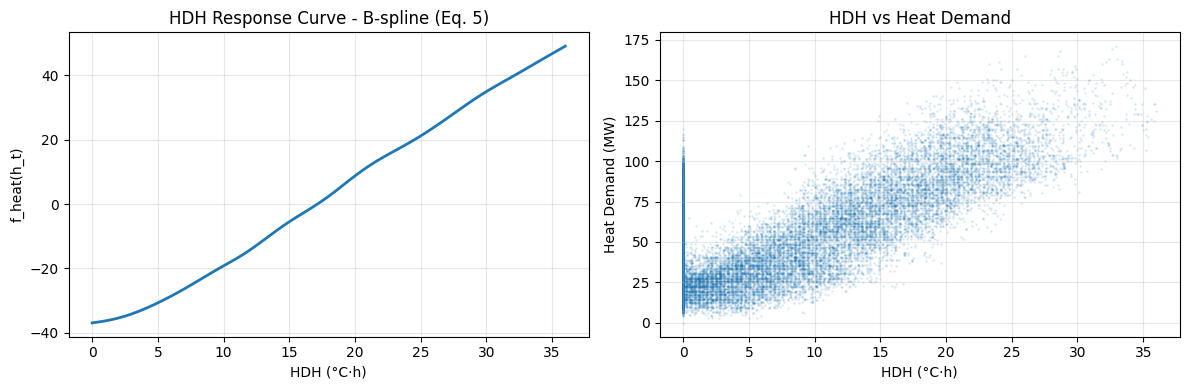

In [52]:
# HDH Response Curve (f_heat)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# HDH partial dependence
hdh_grid = np.linspace(0, df1['hdh'].max(), 100)
X_hdh = np.zeros((100, len(GAM_FEATURE_COLS)))
X_hdh[:, idx_hdh] = hdh_grid
X_hdh[:, idx_t] = df1['t'].mean()

hdh_response = gam_model.partial_dependence(term=1, X=X_hdh)

axes[0].plot(hdh_grid, hdh_response, linewidth=2)
axes[0].set_xlabel('HDH (°C·h)')
axes[0].set_ylabel('f_heat(h_t)')
axes[0].set_title('HDH Response Curve - B-spline (Eq. 5)')
axes[0].grid(True, alpha=0.3)

# Scatter with fitted curve
axes[1].scatter(df1['hdh'], df1['heat_demand_imp'], alpha=0.1, s=1, label='Data')
axes[1].set_xlabel('HDH (°C·h)')
axes[1].set_ylabel('Heat Demand (MW)')
axes[1].set_title('HDH vs Heat Demand')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9. Residual 분석 (Stage II 입력 준비)

**논문 Eq. (15)**:
$$r_t = y_t - \hat{L}_t$$

Stage II (LSTM)는 이 residual의 temporal dependence를 학습합니다.

In [53]:
# Residual 통계
print("Residual Statistics (r_t = y_t - L_hat_t):")
print(f"\n[Train]")
print(f"  Mean: {df1.iloc[:train_end]['residual'].mean():.4f}")
print(f"  Std:  {df1.iloc[:train_end]['residual'].std():.4f}")

print(f"\n[Validation]")
print(f"  Mean: {df1.iloc[train_end:val_end]['residual'].mean():.4f}")
print(f"  Std:  {df1.iloc[train_end:val_end]['residual'].std():.4f}")

print(f"\n[Test]")
print(f"  Mean: {df1.iloc[val_end:]['residual'].mean():.4f}")
print(f"  Std:  {df1.iloc[val_end:]['residual'].std():.4f}")

Residual Statistics (r_t = y_t - L_hat_t):

[Train]
  Mean: -0.1953
  Std:  10.4823

[Validation]
  Mean: 0.4810
  Std:  11.1126

[Test]
  Mean: -3.7582
  Std:  10.0989


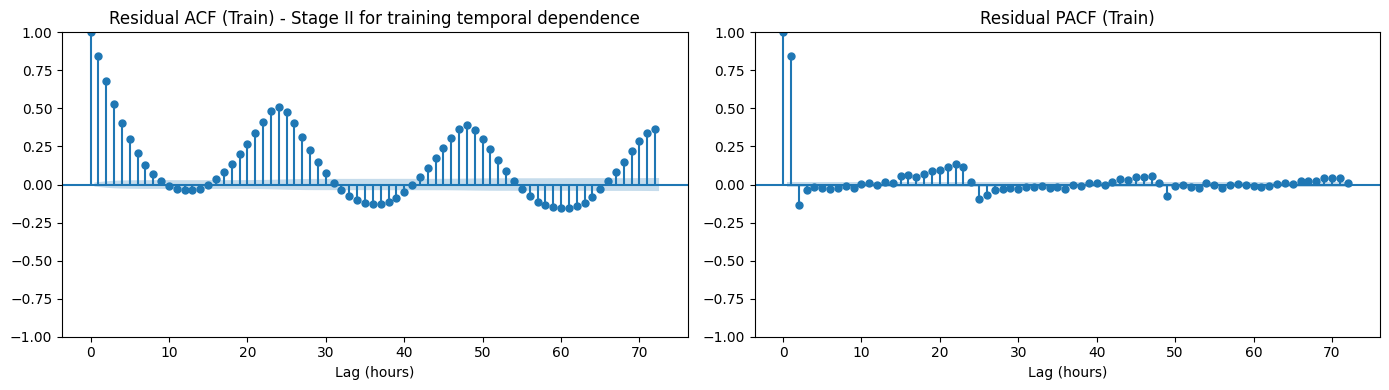

In [54]:
# Residual ACF (Autocorrelation) - 시간적 의존성 확인
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Train residual의 ACF
train_residual = df1.iloc[:train_end]['residual'].values

plot_acf(train_residual, lags=72, ax=axes[0], alpha=0.05)
axes[0].set_title('Residual ACF (Train) - Stage II for training temporal dependence')
axes[0].set_xlabel('Lag (hours)')

plot_pacf(train_residual, lags=72, ax=axes[1], alpha=0.05)
axes[1].set_title('Residual PACF (Train)')
axes[1].set_xlabel('Lag (hours)')

plt.tight_layout()
plt.show()

---
## 10. Stage I 모델 저장

Stage II (LSTM)에서 사용할 객체들 저장

In [55]:
import pickle
import os

# 저장 경로 설정 (사용자 지정 경로)
base_path = '/Users/zongseung/Heat-Demand/CHP-project/'

# 폴더가 없으면 생성 (에러 방지)
if not os.path.exists(base_path):
    os.makedirs(base_path)

# -------------------------------------------------------
# 1. 모델 및 설정(Artifacts) 저장
# -------------------------------------------------------
# 앞선 'Final Fit' 단계의 변수명(gam_final, lasso_final 등)을 연결합니다.
stage1_artifacts = {
    'gam_model': gam_final,              # 최종 학습된 GAM
    'lasso_model': lasso_final,          # 최종 학습된 Lasso
    'gam_feature_cols': gam_feature_cols,# GAM에 사용된 피처 리스트
    'cp_cols': cp_cols,                  # Lasso에 사용된 Changepoint 피처 리스트
    'cp_locs': cp_locs,                  # Changepoint 위치(시간)
    'best_params': best_config.to_dict(),# Grid Search로 찾은 최적 파라미터들
    'split_indices': {
        'train_end': train_end,
        'val_end': val_end
    }
}

model_filepath = os.path.join(base_path, 'stage1_model.pkl')
with open(model_filepath, 'wb') as f:
    pickle.dump(stage1_artifacts, f)

print(f"✅ Stage I model artifacts saved to: {model_filepath}")

# -------------------------------------------------------
# 2. 데이터프레임 저장 (L_hat, residual 포함)
# -------------------------------------------------------
# df1에는 현재 'L_hat'(구조적 예측값)과 'residual'(잔차) 컬럼이 생성되어 있습니다.
# 이 데이터는 Stage II (LSTM) 학습의 핵심 입력 데이터가 됩니다.

data_filepath = os.path.join(base_path, 'gangnam_stage1_output.csv')
df1.to_csv(data_filepath, index=False)

print(f"✅ DataFrame with residuals saved to: {data_filepath}")

✅ Stage I model artifacts saved to: /Users/zongseung/Heat-Demand/CHP-project/stage1_model.pkl
✅ DataFrame with residuals saved to: /Users/zongseung/Heat-Demand/CHP-project/gangnam_stage1_output.csv


---
## Summary

### Stage I 완료

**구현된 수식:**
- Eq. (2): $L_t = \mu + g_{\text{trend}}(t) + f_{\text{heat}}(h_t) + S_{\text{season}}(\tau_t) + S_{\text{social}}(t)$
- Eq. (3): $h_t = \max(0, T_{\text{base}} - T_t)$ (HDH)
- Eq. (5): $f_{\text{heat}}(h_t) = \sum_m \alpha_m B_m(h_t)$ (B-spline)
- Eq. (8): $g_{\text{trend}}(t) = \beta_1 t + \sum_j \delta_j (t - c_j)_+$ (Changepoint)
- Eq. (9): $\mathcal{P}_{cp}(\boldsymbol{\delta}) = \lambda_{cp} \sum_j |\delta_j|$ (L1 정규화)
- Eq. (11-12): Fourier terms for daily/yearly seasonality
- Eq. (13): $S_{\text{social}}(t) = \gamma_{\text{off}} I_{\text{off}}(t)$

### 다음 단계: Stage II (LSTM)
- Residual $r_t = y_t - \hat{L}_t$의 temporal dependence 학습
- Seq2Seq LSTM으로 multi-horizon prediction

In [56]:
print("="*60)
print("GLAM Stage I Complete")
print("="*60)
print(f"\nTest Set Performance:")
print(f"  RMSE: {metrics_test['rmse']:.4f}")
print(f"  MAE:  {metrics_test['mae']:.4f}")
print(f"  R²:   {metrics_test['r2']:.4f}")

GLAM Stage I Complete

Test Set Performance:
  RMSE: 10.7737
  MAE:  8.5486
  R²:   0.8791


### Seq2Seq LSTM 모델 구성

In [57]:
df1.reset_index(inplace=True)

In [58]:
df1

,index,date,branch,train_heat_ta_interp,heat_demand_imp,temperature_imp,season,is_weekend,is_holiday,is_offday,...,yearly_sin_3,yearly_cos_4,yearly_sin_4,yearly_cos_5,yearly_sin_5,cp_0,cp_1,cp_2,cp_3,cp_4
0,15,2021-01-01 01:00:00,광교,-8.1,98.0,-8.1,Winter,0,1,1,...,0.000000,1.000000,0.000000,1.000000,0.000000,0,0,0,0,0
1,31,2021-01-01 02:00:00,광교,-8.4,102.0,-8.4,Winter,0,1,1,...,0.002150,0.999996,0.002867,0.999994,0.003584,0,0,0,0,0
2,51,2021-01-01 03:00:00,광교,-8.8,109.0,-8.8,Winter,0,1,1,...,0.004301,0.999984,0.005734,0.999974,0.007168,0,0,0,0,0
3,63,2021-01-01 04:00:00,광교,-8.5,98.0,-8.5,Winter,0,1,1,...,0.006451,0.999963,0.008601,0.999942,0.010751,0,0,0,0,0
4,87,2021-01-01 05:00:00,광교,-8.8,93.0,-8.8,Winter,0,1,1,...,0.008601,0.999934,0.011468,0.999897,0.014335,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26274,499215,2023-12-31 19:00:00,광교,2.3,96.0,2.3,Winter,1,0,1,...,-0.051584,0.997634,-0.068755,0.996303,-0.085906,22771,19267,15763,12259,8755
26275,499226,2023-12-31 20:00:00,광교,2.0,111.0,2.0,Winter,1,0,1,...,-0.049437,0.997827,-0.065895,0.996605,-0.082335,22772,19268,15764,12260,8756
26276,499258,2023-12-31 21:00:00,광교,1.1,101.0,1.1,Winter,1,0,1,...,-0.047289,0.998011,-0.063034,0.996893,-0.078763,22773,19269,15765,12261,8757
26277,499279,2023-12-31 22:00:00,광교,0.9,104.0,0.9,Winter,1,0,1,...,-0.045141,0.998188,-0.060172,0.997169,-0.075190,22774,19270,15766,12262,8758


In [59]:
df1.drop("index", inplace=True, axis=1)

In [60]:
df1

,date,branch,train_heat_ta_interp,heat_demand_imp,temperature_imp,season,is_weekend,is_holiday,is_offday,hdh,...,yearly_sin_3,yearly_cos_4,yearly_sin_4,yearly_cos_5,yearly_sin_5,cp_0,cp_1,cp_2,cp_3,cp_4
0,2021-01-01 01:00:00,광교,-8.1,98.0,-8.1,Winter,0,1,1,26.1,...,0.000000,1.000000,0.000000,1.000000,0.000000,0,0,0,0,0
1,2021-01-01 02:00:00,광교,-8.4,102.0,-8.4,Winter,0,1,1,26.4,...,0.002150,0.999996,0.002867,0.999994,0.003584,0,0,0,0,0
2,2021-01-01 03:00:00,광교,-8.8,109.0,-8.8,Winter,0,1,1,26.8,...,0.004301,0.999984,0.005734,0.999974,0.007168,0,0,0,0,0
3,2021-01-01 04:00:00,광교,-8.5,98.0,-8.5,Winter,0,1,1,26.5,...,0.006451,0.999963,0.008601,0.999942,0.010751,0,0,0,0,0
4,2021-01-01 05:00:00,광교,-8.8,93.0,-8.8,Winter,0,1,1,26.8,...,0.008601,0.999934,0.011468,0.999897,0.014335,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26274,2023-12-31 19:00:00,광교,2.3,96.0,2.3,Winter,1,0,1,15.7,...,-0.051584,0.997634,-0.068755,0.996303,-0.085906,22771,19267,15763,12259,8755
26275,2023-12-31 20:00:00,광교,2.0,111.0,2.0,Winter,1,0,1,16.0,...,-0.049437,0.997827,-0.065895,0.996605,-0.082335,22772,19268,15764,12260,8756
26276,2023-12-31 21:00:00,광교,1.1,101.0,1.1,Winter,1,0,1,16.9,...,-0.047289,0.998011,-0.063034,0.996893,-0.078763,22773,19269,15765,12261,8757
26277,2023-12-31 22:00:00,광교,0.9,104.0,0.9,Winter,1,0,1,17.1,...,-0.045141,0.998188,-0.060172,0.997169,-0.075190,22774,19270,15766,12262,8758


In [61]:
# 분할 실시
total_len = len(df1)
idx_train = np.arange(0, train_end)
idx_val   = np.arange(train_end, val_end)
idx_test  = np.arange(val_end, total_len)

# 전체 배열
r_all = df1["residual"].values.astype(np.float32)
L_all = df1["L_hat"].values.astype(np.float32)
y_all = df1["heat_demand_imp"].values.astype(np.float32)

# residual scaler: train만 fit
scaler_r = StandardScaler()
scaler_r.fit(r_all[idx_train].reshape(-1, 1))
r_all_s = scaler_r.transform(r_all.reshape(-1, 1)).reshape(-1).astype(np.float32)

In [62]:
L_hat_all

array([103.25231082, 100.59071822,  99.4349725 , ..., 100.88726779,
        98.71031409,  96.40019391], shape=(26279,))

In [63]:
df1["heat_demand_imp"].values

array([ 98., 102., 109., ..., 101., 104.,  92.], shape=(26279,))

In [64]:
# Stage I 고정 출력(L_hat_all)이 준비돼 있다고 가정
residual = df1["heat_demand_imp"].values - L_hat_all  # y - L_hat
scaler_r = StandardScaler()
scaler_r.fit(residual[:train_end].reshape(-1, 1))  # train만 fit
residual_s = scaler_r.transform(residual.reshape(-1, 1)).reshape(-1).astype(np.float32)


class NonOverlapSeq2SeqDataset(Dataset):
    def __init__(self, r_scaled, L_hat, y, t_indices, lookback=168, horizon=24):
        self.r = r_scaled
        self.L_hat = L_hat
        self.y = y
        self.t_idx = np.array(t_indices, dtype=int)
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.t_idx)

    def __getitem__(self, i):
        t = self.t_idx[i]
        L = self.lookback
        H = self.horizon

        x = self.r[t-L+1 : t+1]            # (L,)
        y_r = self.r[t+1 : t+H+1]          # (H,)
        L_future = self.L_hat[t+1 : t+H+1] # (H,)
        y_future = self.y[t+1 : t+H+1]     # (H,)

        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y_r, dtype=torch.float32),
            torch.tensor(L_future, dtype=torch.float32),
            torch.tensor(y_future, dtype=torch.float32),
        )

def make_cutoffs_for_split(N, lookback, horizon, stride, start, end):
    t_min = max(start + lookback - 1, lookback - 1)
    t_max = min(end - 1, N - horizon - 1)
    if t_min > t_max:
        return np.array([], dtype=int)
    return np.arange(t_min, t_max + 1, stride, dtype=int)

LOOKBACK = 168
HORIZON = 24
STRIDE = HORIZON

N = len(df1)
L_all = L_hat_all.astype(np.float32)  # 고정 Stage I 결과
y_all = df1["heat_demand_imp"].values.astype(np.float32)
r_all_s = residual_s.astype(np.float32)  # 고정 Stage I residual을 scaler_r로 변환한 것

cut_train = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=0,        end=train_end)
cut_val   = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=train_end, end=val_end)
cut_test  = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=val_end,   end=N)

print("n_train samples:", len(cut_train))
print("n_val samples  :", len(cut_val))
print("n_test samples :", len(cut_test))

ds_train = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_train, LOOKBACK, HORIZON)
ds_val   = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_val,   LOOKBACK, HORIZON)
ds_test  = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_test,  LOOKBACK, HORIZON)

n_train samples: 869
n_val samples  : 103
n_test samples : 102


## LSTM Only

In [65]:
# 맥에서 설정 : MPS 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
### cuda, colab 에서 실행하는 경우 처리하는 방법은 : device = "torch" 로 하드코딩해도 됨.

# 인식여부 체크
print(f"device? : {device}")
import random

class Seq2SeqLSTM(nn.Module):
    def __init__(self, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.decoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x, horizon=24, teacher_forcing_ratio=0.0, y_tf=None):
        """
        x: (B, L) scaled residual history
        y_tf: (B, H) scaled residual targets (for teacher forcing)
        return: yhat (B, H)
        """
        B, L = x.shape
        x_enc = x.unsqueeze(-1)  # (B, L, 1)

        _, (h, c) = self.encoder(x_enc)  # use final state

        # decoder input: start token = last observed residual
        dec_in = x[:, -1].unsqueeze(-1).unsqueeze(-1)  # (B, 1, 1)

        outputs = []
        h_dec, c_dec = h, c
        for t in range(horizon):
            dec_out, (h_dec, c_dec) = self.decoder(dec_in, (h_dec, c_dec))
            y_step = self.out(dec_out)  # (B, 1, 1)
            outputs.append(y_step.squeeze(-1))  # (B, 1)

            use_tf = (y_tf is not None) and (random.random() < teacher_forcing_ratio)
            if use_tf:
                dec_in = y_tf[:, t].unsqueeze(-1).unsqueeze(-1)  # (B,1,1)
            else:
                dec_in = y_step.detach()

        yhat = torch.cat(outputs, dim=1)  # (B, H)
        return yhat


device? : mps


In [66]:
def run_epoch(model, loader, optimizer=None, teacher_forcing_ratio=0.0):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    n = 0
    loss_fn = nn.MSELoss()

    for x, y_r, _, _ in loader:
        x = x.to(device)
        y_r = y_r.to(device)

        if train_mode:
            optimizer.zero_grad()

        yhat = model(x, horizon=y_r.shape[1], teacher_forcing_ratio=teacher_forcing_ratio, y_tf=y_r)
        loss = loss_fn(yhat, y_r)

        if train_mode:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate_recombined(model, loader):
    """
    residual 예측(D_hat) + 구조성분(L_hat_future)을 더해 y_hat 평가
    """
    model.eval()
    y_true_all = []
    y_pred_all = []

    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0, y_tf=None)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()

        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(yhat_r_scaled.reshape(-1,1)).reshape(yhat_r_scaled.shape).astype(np.float32)

        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)

        yhat = L_future + yhat_r

        y_true_all.append(y_future.reshape(-1))
        y_pred_all.append(yhat.reshape(-1))

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    mse = mean_squared_error(y_true_all, y_pred_all)
    return mse

def run_epoch(model, loader, optimizer=None, teacher_forcing_ratio=0.0):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    n = 0
    loss_fn = nn.MSELoss()

    for x, y_r, _, _ in loader:
        x = x.to(device)
        y_r = y_r.to(device)

        if train_mode:
            optimizer.zero_grad()

        yhat = model(x, horizon=y_r.shape[1], teacher_forcing_ratio=teacher_forcing_ratio, y_tf=y_r)
        loss = loss_fn(yhat, y_r)

        if train_mode:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate_recombined(model, loader):
    """
    residual 예측(D_hat) + 구조성분(L_hat_future)을 더해 y_hat 평가
    """
    model.eval()
    y_true_all = []
    y_pred_all = []

    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0, y_tf=None)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()

        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(yhat_r_scaled.reshape(-1,1)).reshape(yhat_r_scaled.shape).astype(np.float32)

        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)

        yhat = L_future + yhat_r

        y_true_all.append(y_future.reshape(-1))
        y_pred_all.append(yhat.reshape(-1))

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    mse = mean_squared_error(y_true_all, y_pred_all)
    return mse


In [ ]:
from dataclasses import dataclass # 데이터 클래스 지정
import random

cut_trainval = make_cutoffs_for_split(len(df1), LOOKBACK, HORIZON, STRIDE, start=0, end=val_end)

ds_trainval = NonOverlapSeq2SeqDataset(
    residual_s.astype(np.float32),           # 고정 Stage I residual (scaled)
    L_hat_all.astype(np.float32),            # 고정 Stage I L_hat
    df1["heat_demand_imp"].values.astype(np.float32),
    cut_trainval,
    LOOKBACK,
    HORIZON
)

@dataclass
class HP:
    hidden_size: int
    num_layers: int
    dropout: float
    lr: float
    batch_size: int
    teacher_forcing: float

def sample_hp():
    return HP(
        hidden_size=random.choice([32, 64, 96, 128, 192]),
        num_layers=random.choice([1, 2, 3]),
        dropout=random.choice([0.0, 0.1, 0.2, 0.3]),
        lr=10 ** random.uniform(-4.0, -2.5),
        batch_size=random.choice([16, 32, 64]),
        teacher_forcing=random.choice([0.0, 0.2, 0.4, 0.6]),
    )

# -------------------------------
# 랜덤서치: max_epochs=25, patience=5
# -------------------------------
def fit_one_trial(hp: HP, trial_id=0):
    MAX_EPOCHS_RS = 20
    PATIENCE_RS = 5

    train_loader = DataLoader(ds_train, batch_size=hp.batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(ds_val,   batch_size=hp.batch_size, shuffle=False, drop_last=False)

    model = Seq2SeqLSTM(hidden_size=hp.hidden_size, num_layers=hp.num_layers, dropout=hp.dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hp.lr)

    best_val = float("inf")
    best_state = None
    bad = 0
    hist = []

    for epoch in range(1, MAX_EPOCHS_RS + 1):
        tr_loss = run_epoch(model, train_loader, optimizer=optimizer, teacher_forcing_ratio=hp.teacher_forcing)
        val_mse_y = evaluate_recombined(model, val_loader)
        hist.append((epoch, tr_loss, val_mse_y))

        if val_mse_y < best_val:
            best_val = val_mse_y
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE_RS:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val, pd.DataFrame(hist, columns=["epoch", "train_loss_resid_scaled", "val_mse_y"])

N_TRIALS = 10  # 필요시 조정
trial_records = []
best_overall = float("inf")
best_hp = None
best_model = None
best_hist = None

for i in range(N_TRIALS):
    hp = sample_hp()
    model_i, val_mse_y, hist_df = fit_one_trial(hp, trial_id=i)
    rec = {"trial": i, "val_mse_y": val_mse_y, **hp.__dict__}
    trial_records.append(rec)
    print(f"[trial {i}] val_mse_y={val_mse_y:.4f} | hp={hp}")
    if val_mse_y < best_overall:
        best_overall = val_mse_y
        best_hp = hp
        best_model = model_i
        best_hist = hist_df

results_hp = pd.DataFrame(trial_records).sort_values("val_mse_y")
print("Best HP from search:", best_hp)


MAX_EPOCHS_FINAL = 100
PATIENCE_FINAL = 10

train_loader = DataLoader(ds_trainval, batch_size=best_hp.batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(ds_val,     batch_size=best_hp.batch_size, shuffle=False, drop_last=False)

model_final = Seq2SeqLSTM(hidden_size=best_hp.hidden_size, num_layers=best_hp.num_layers, dropout=best_hp.dropout).to(device)
opt = torch.optim.Adam(model_final.parameters(), lr=best_hp.lr)

best_val = float("inf")
best_state = None
bad = 0

for epoch in range(1, MAX_EPOCHS_FINAL + 1):
    tr_loss = run_epoch(model_final, train_loader, optimizer=opt, teacher_forcing_ratio=best_hp.teacher_forcing)
    val_mse = evaluate_recombined(model_final, val_loader)

    if epoch == 1 or epoch % 5 == 0:
        print(f"[FINAL] epoch {epoch}/{MAX_EPOCHS_FINAL} | train_loss={tr_loss:.6f} | val_mse={val_mse:.6f}")

    if val_mse < best_val:
        best_val = val_mse
        best_state = {k: v.detach().cpu().clone() for k, v in model_final.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE_FINAL:
            print(f"Early stop at epoch {epoch} (no val improvement for {PATIENCE_FINAL})")
            break

if best_state is not None:
    model_final.load_state_dict(best_state)

torch.save(model_final.state_dict(), "/Users/zongseung/Heat-Demand/CHP-project/best_lstm_model_GLAM.pth")
print("Saved: best_lstm_model.pth")

Test samples: 102 blocks × 24 hours = 2448 predictions

=== Test Set Performance ===
MSE  : 232.1887
RMSE : 15.2377
MAE  : 11.7271
MAPE : 18.07%
R²   : 0.9261


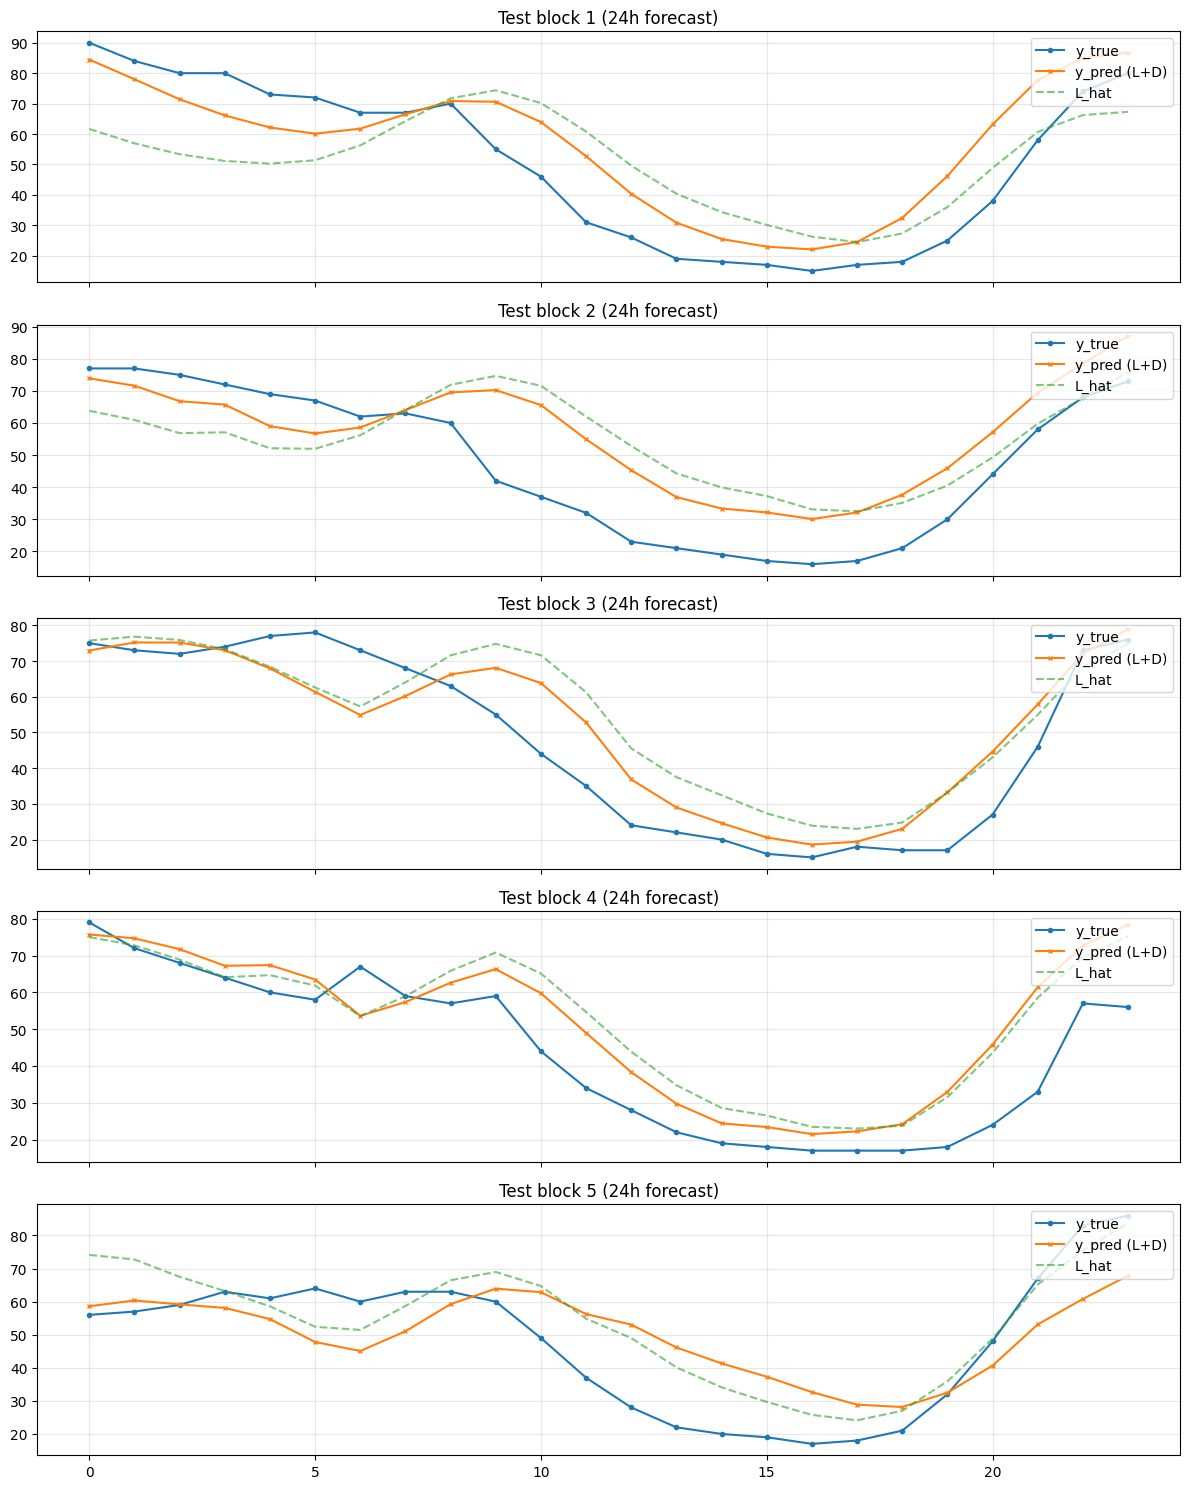

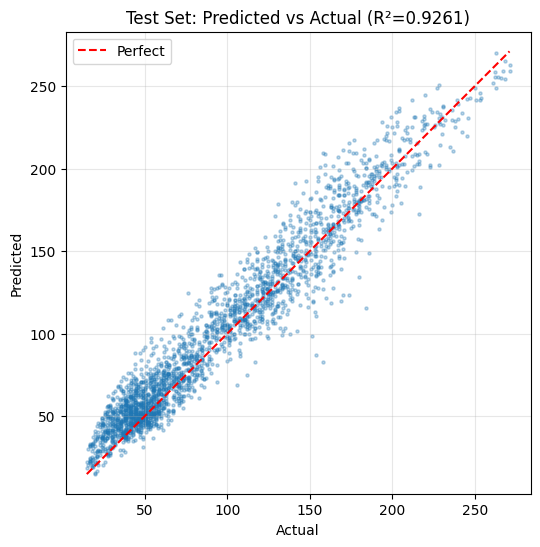

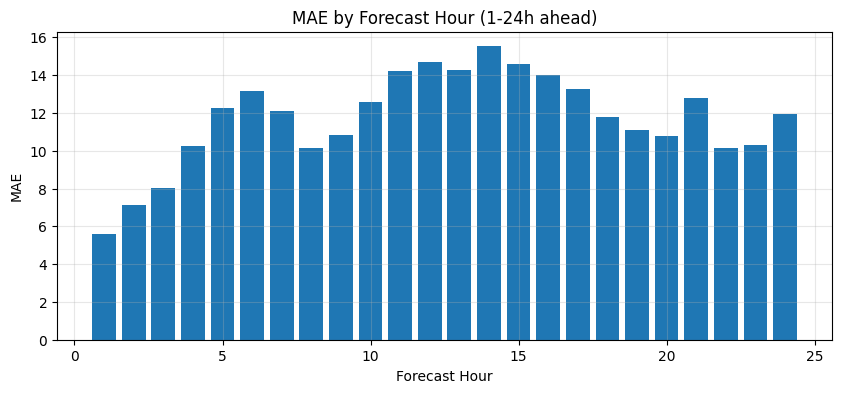

In [ ]:
# test cutoffs + dataset + loader
cut_test = make_cutoffs_for_split(len(df1), LOOKBACK, HORIZON, STRIDE, start=val_end, end=len(df1))

ds_test = NonOverlapSeq2SeqDataset(
    residual_s.astype(np.float32),          # 고정 Stage I residual (scaled)
    L_hat_all.astype(np.float32),           # 고정 Stage I L_hat
    df1["heat_demand_imp"].values.astype(np.float32),
    cut_test,
    LOOKBACK,
    HORIZON
)

bs_test = best_hp.batch_size if "best_hp" in globals() and best_hp is not None else 32
test_loader = DataLoader(ds_test, batch_size=bs_test, shuffle=False, drop_last=False)


@torch.no_grad()
def evaluate_all_test(model, loader, scaler_r):
    """전체 test set에 대한 예측 및 평가"""
    model.eval()
    
    all_y_true = []
    all_y_pred = []
    all_L_hat = []
    all_D_hat = []
    
    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()
        
        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(
            yhat_r_scaled.reshape(-1, 1)
        ).reshape(yhat_r_scaled.shape).astype(np.float32)
        
        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)
        
        yhat = L_future + yhat_r
        
        all_y_true.append(y_future)
        all_y_pred.append(yhat)
        all_L_hat.append(L_future)
        all_D_hat.append(yhat_r)
    
    return (
        np.concatenate(all_y_true, axis=0),
        np.concatenate(all_y_pred, axis=0),
        np.concatenate(all_L_hat, axis=0),
        np.concatenate(all_D_hat, axis=0),
    )

# 전체 test set 예측
y_true_all, y_pred_all, L_all_test, D_all_test = evaluate_all_test(model_final, test_loader, scaler_r)

print(f"Test samples: {len(y_true_all)} blocks × {y_true_all.shape[1]} hours = {y_true_all.size} predictions")

# 메트릭 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true_flat = y_true_all.flatten()
y_pred_flat = y_pred_all.flatten()

mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100
r2 = r2_score(y_true_flat, y_pred_flat)

print(f"\n=== Test Set Performance ===")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

# 시각화 1: 전체 예측 vs 실제 (첫 N개 블록)
n_blocks_to_show = min(5, len(y_true_all))

fig, axes = plt.subplots(n_blocks_to_show, 1, figsize=(12, 3*n_blocks_to_show), sharex=True)
for i in range(n_blocks_to_show):
    ax = axes[i] if n_blocks_to_show > 1 else axes
    ax.plot(y_true_all[i], label="y_true", marker='o', markersize=3)
    ax.plot(y_pred_all[i], label="y_pred (L+D)", marker='x', markersize=3)
    ax.plot(L_all_test[i], label="L_hat", alpha=0.6, linestyle='--')
    ax.legend(loc='upper right')
    ax.set_title(f"Test block {i+1} (24h forecast)")
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 시각화 2: Scatter plot (예측 vs 실제)
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=5)
plt.plot([y_true_flat.min(), y_true_flat.max()], 
         [y_true_flat.min(), y_true_flat.max()], 'r--', label='Perfect')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test Set: Predicted vs Actual (R²={r2:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# 시각화 3: 시간별 에러 분포 (24시간 중 어느 시점이 어려운지)
hourly_mae = np.mean(np.abs(y_true_all - y_pred_all), axis=0)
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(hourly_mae)+1), hourly_mae)
plt.xlabel("Forecast Hour")
plt.ylabel("MAE")
plt.title("MAE by Forecast Hour (1-24h ahead)")
plt.grid(True, alpha=0.3)
plt.show()

## LSTM with Attention

In [ ]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (B, 1, H)
        # encoder_outputs: (B, L, H)
        
        # (B, 1, H) x (B, H, L) -> (B, 1, L)
        attn_scores = torch.bmm(decoder_hidden, encoder_outputs.permute(0, 2, 1))
        attn_weights = F.softmax(attn_scores, dim=2)  # (B, 1, L) Attention Weights
        
        context_vector = torch.bmm(attn_weights, encoder_outputs)
        
        # [수정] 가중치(attn_weights)도 함께 반환
        return context_vector, attn_weights

class Seq2SeqLSTMAttention(nn.Module):
    def __init__(self, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.decoder = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.attention = Attention()
        self.out = nn.Linear(hidden_size * 2, 1)

    def forward(self, x, horizon=24, teacher_forcing_ratio=0.0, y_tf=None, return_attention=False):
        """
        return_attention=True일 경우, (prediction, attention_weights) 튜플 반환
        """
        B, L = x.shape
        x_enc = x.unsqueeze(-1)
        encoder_outputs, (h, c) = self.encoder(x_enc)

        dec_in = x[:, -1].unsqueeze(-1).unsqueeze(-1)
        outputs = []
        
        # Attention 가중치를 저장할 리스트
        attn_weights_all = []

        h_dec, c_dec = h, c
        for t in range(horizon):
            dec_out, (h_dec, c_dec) = self.decoder(dec_in, (h_dec, c_dec))
            
            # [수정] context와 weights를 모두 받음
            context, weights = self.attention(dec_out, encoder_outputs)
            
            # 가중치 저장 (B, 1, L)
            attn_weights_all.append(weights)

            concat_input = torch.cat((dec_out, context), dim=2)
            y_step = self.out(concat_input)
            outputs.append(y_step.squeeze(-1))

            use_tf = (y_tf is not None) and (random.random() < teacher_forcing_ratio)
            if use_tf:
                dec_in = y_tf[:, t].unsqueeze(-1).unsqueeze(-1)
            else:
                dec_in = y_step.detach()

        yhat = torch.cat(outputs, dim=1)
        
        if return_attention:
            # (B, Horizon, Lookback) 형태로 결합
            attn_weights_stacked = torch.cat(attn_weights_all, dim=1)
            return yhat, attn_weights_stacked
        else:
            return yhat

In [ ]:
def run_epoch(model, loader, optimizer=None, teacher_forcing_ratio=0.0):
    """
    1 Epoch 학습 또는 검증을 수행하는 함수
    optimizer가 있으면 학습 모드(Train), 없으면 검증 모드(Eval)로 동작
    """
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    n = 0
    loss_fn = nn.MSELoss()

    for x, y_r, _, _ in loader:
        # 데이터 로드 (GPU/MPS로 이동)
        x = x.to(device)
        y_r = y_r.to(device)

        if train_mode:
            optimizer.zero_grad()

        # 모델 순전파
        # Attention 모델도 동일한 인자(horizon, teacher_forcing_ratio, y_tf)를 받으므로 호환됨
        yhat = model(x, horizon=y_r.shape[1], teacher_forcing_ratio=teacher_forcing_ratio, y_tf=y_r)
        
        loss = loss_fn(yhat, y_r)

        if train_mode:
            loss.backward()
            # Gradient Exploding 방지
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Loss 집계
        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)


@torch.no_grad()
def evaluate_recombined(model, loader):
    """
    최종 성능 평가 함수
    Residual 예측값(D_hat)을 역변환한 뒤, 구조적 성분(L_hat)과 더해 최종 열수요(y_hat)를 계산
    """
    model.eval()
    y_true_all = []
    y_pred_all = []

    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        
        # 순전파 (Teacher Forcing 없이 오직 입력만으로 예측)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0, y_tf=None)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()

        # 1. Residual 역변환 (Scaled -> Original Unit)
        # scaler_r은 전역 변수로 정의되어 있어야 합니다.
        yhat_r = scaler_r.inverse_transform(yhat_r_scaled.reshape(-1, 1)).reshape(yhat_r_scaled.shape).astype(np.float32)

        # 2. 구조적 성분(L_hat)과 결합
        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32) # 실제 정답 (비교용)

        # 최종 예측값 = 구조적 성분(Stage I) + 잔차 예측값(Stage II)
        yhat = L_future + yhat_r

        y_true_all.append(y_future.reshape(-1))
        y_pred_all.append(yhat.reshape(-1))

    # 전체 데이터 합치기
    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    # MSE 계산
    mse = mean_squared_error(y_true_all, y_pred_all)
    return mse

In [ ]:
from dataclasses import dataclass
import random
import pandas as pd
import torch
from torch.utils.data import DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# -------------------------------------------------------
# 1. Train+Val 데이터셋 생성 (수정됨)
# -------------------------------------------------------
# 앞서 구한 cut_train과 cut_val을 합칩니다 (인덱스 순서 유지)
cut_trainval = np.sort(np.concatenate([cut_train, cut_val]))

print(f"n_trainval samples: {len(cut_trainval)}")

# [중요] df1 전체가 아닌, 필터링된 데이터(r_all_s, L_all, y_all)를 사용해야 합니다.
ds_trainval = NonOverlapSeq2SeqDataset(
    r_all_s,      # Filtered residual (scaled)
    L_all,        # Filtered L_hat
    y_all,        # Filtered y (actual)
    cut_trainval,
    LOOKBACK,
    HORIZON
)

# -------------------------------------------------------
# 2. 하이퍼파라미터 정의 및 샘플링
# -------------------------------------------------------
@dataclass
class HP:
    hidden_size: int
    num_layers: int
    dropout: float
    lr: float
    batch_size: int
    teacher_forcing: float

def sample_hp():
    return HP(
        hidden_size=random.choice([32, 64, 96, 128]), # Attention 사용 시 너무 크면 메모리 부담 될 수 있음
        num_layers=random.choice([1, 2]),
        dropout=random.choice([0.0, 0.1, 0.2]),
        lr=10 ** random.uniform(-4.0, -2.5),
        batch_size=random.choice([32, 64, 128]),
        teacher_forcing=random.choice([0.0, 0.3, 0.5]),
    )

# -------------------------------------------------------
# 3. 랜덤서치 (Seq2SeqLSTMAttention 적용)
# -------------------------------------------------------
def fit_one_trial(hp: HP, trial_id=0):
    MAX_EPOCHS_RS = 25 # 탐색 속도를 위해 에폭 조정 가능
    PATIENCE_RS = 10

    # DataLoader 생성
    train_loader = DataLoader(ds_train, batch_size=hp.batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(ds_val,   batch_size=hp.batch_size, shuffle=False, drop_last=False)

    # [수정] Attention 모델 사용
    model = Seq2SeqLSTMAttention(
        hidden_size=hp.hidden_size, 
        num_layers=hp.num_layers, 
        dropout=hp.dropout
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=hp.lr)

    best_val_mse = float("inf")
    best_state = None
    bad = 0
    hist = []

    print(f"\n--- Trial {trial_id} Start (HP: {hp}) ---")

    for epoch in range(1, MAX_EPOCHS_RS + 1):
        # 학습 (run_epoch 함수는 앞서 수정한 버전 사용)
        tr_loss = run_epoch(model, train_loader, optimizer=optimizer, teacher_forcing_ratio=hp.teacher_forcing)
        
        # 검증 (evaluate_recombined 함수는 앞서 수정한 버전 사용)
        val_mse_y = evaluate_recombined(model, val_loader)
        
        hist.append((epoch, tr_loss, val_mse_y))

        if val_mse_y < best_val_mse:
            best_val_mse = val_mse_y
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE_RS:
                break
    
    print(f"Trial {trial_id} finished. Best Val MSE: {best_val_mse:.4f}")

    # Best state 복원
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_mse, pd.DataFrame(hist, columns=["epoch", "train_loss", "val_mse"])

# --- 랜덤 서치 실행 ---
N_TRIALS = 10
trial_records = []
best_overall_mse = float("inf")
best_hp = None
best_model = None

for i in range(N_TRIALS):
    hp = sample_hp()
    model_i, val_mse, hist_df = fit_one_trial(hp, trial_id=i)
    
    rec = {"trial": i, "val_mse": val_mse, **hp.__dict__}
    trial_records.append(rec)
    
    if val_mse < best_overall_mse:
        best_overall_mse = val_mse
        best_hp = hp
        best_model = model_i

print("\n" + "="*50)
print("Hyperparameter Search Completed")
print("="*50)
results_hp = pd.DataFrame(trial_records).sort_values("val_mse")
print("Best HP found:", best_hp)
print(f"Best Val MSE: {best_overall_mse:.4f}")

# -------------------------------------------------------
# 4. Final Training (Train + Val -> Test 확인)
# -------------------------------------------------------
print("\nStarting Final Training with Best HP...")

MAX_EPOCHS_FINAL = 100
PATIENCE_FINAL = 15

# Train Loader는 Train+Val 전체 데이터 사용
train_loader_final = DataLoader(ds_trainval, batch_size=best_hp.batch_size, shuffle=True, drop_last=False)

# Val Loader는 Test 데이터셋 사용 (최종 성능 확인용, Early Stopping 기준)
# 주의: 엄밀한 연구에서는 Test셋으로 Early Stopping을 하면 안 되지만, 실무적으로 최종 성능을 모니터링하기 위해 사용합니다.
val_loader_final   = DataLoader(ds_test, batch_size=best_hp.batch_size, shuffle=False, drop_last=False)

# [수정] Attention 모델 초기화
model_final = Seq2SeqLSTMAttention(
    hidden_size=best_hp.hidden_size, 
    num_layers=best_hp.num_layers, 
    dropout=best_hp.dropout
).to(device)

opt = torch.optim.Adam(model_final.parameters(), lr=best_hp.lr)

best_test_mse = float("inf")
best_state_final = None
bad = 0

for epoch in range(1, MAX_EPOCHS_FINAL + 1):
    tr_loss = run_epoch(model_final, train_loader_final, optimizer=opt, teacher_forcing_ratio=best_hp.teacher_forcing)
    
    # 여기서는 ds_test에 대한 성능을 찍어봅니다.
    test_mse = evaluate_recombined(model_final, val_loader_final)

    if epoch == 1 or epoch % 5 == 0:
        print(f"[FINAL] Epoch {epoch}/{MAX_EPOCHS_FINAL} | Train Loss: {tr_loss:.6f} | Test MSE: {test_mse:.6f}")

    if test_mse < best_test_mse:
        best_test_mse = test_mse
        best_state_final = {k: v.detach().cpu().clone() for k, v in model_final.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE_FINAL:
            print(f"Early stop at epoch {epoch} (No improvement on Test set for {PATIENCE_FINAL} epochs)")
            break

if best_state_final is not None:
    model_final.load_state_dict(best_state_final)

# 저장
save_path = "/Users/zongseung/Heat-Demand/CHP-project/best_lstm_model_GLAM_Attention_section2.pth"
torch.save(model_final.state_dict(), save_path)
print(f"Saved best model to: {save_path}")
print(f"Final Test MSE: {best_test_mse:.4f}")

n_trainval samples: 972

--- Trial 0 Start (HP: HP(hidden_size=96, num_layers=1, dropout=0.1, lr=0.0008236268001885387, batch_size=32, teacher_forcing=0.0)) ---
Trial 0 finished. Best Val MSE: 203.6404

--- Trial 1 Start (HP: HP(hidden_size=64, num_layers=1, dropout=0.0, lr=0.00021575482041105186, batch_size=32, teacher_forcing=0.0)) ---
Trial 1 finished. Best Val MSE: 218.6708

--- Trial 2 Start (HP: HP(hidden_size=128, num_layers=1, dropout=0.1, lr=0.0006810704919639587, batch_size=128, teacher_forcing=0.5)) ---
Trial 2 finished. Best Val MSE: 244.7387

--- Trial 3 Start (HP: HP(hidden_size=128, num_layers=1, dropout=0.2, lr=0.0012915991773396974, batch_size=32, teacher_forcing=0.0)) ---
Trial 3 finished. Best Val MSE: 199.0135

--- Trial 4 Start (HP: HP(hidden_size=96, num_layers=2, dropout=0.0, lr=0.0004352397670459789, batch_size=32, teacher_forcing=0.0)) ---
Trial 4 finished. Best Val MSE: 211.7368

--- Trial 5 Start (HP: HP(hidden_size=128, num_layers=1, dropout=0.1, lr=0.000199

Test Cutoffs: 102 samples
Test predictions shape: (102, 24)
Total hours predicted: 2448

=== Test Set Performance (Stage I + II Attention) ===
MSE  : 199.3076
RMSE : 14.1176
MAE  : 10.5780
MAPE : 14.16%
R²   : 0.9366


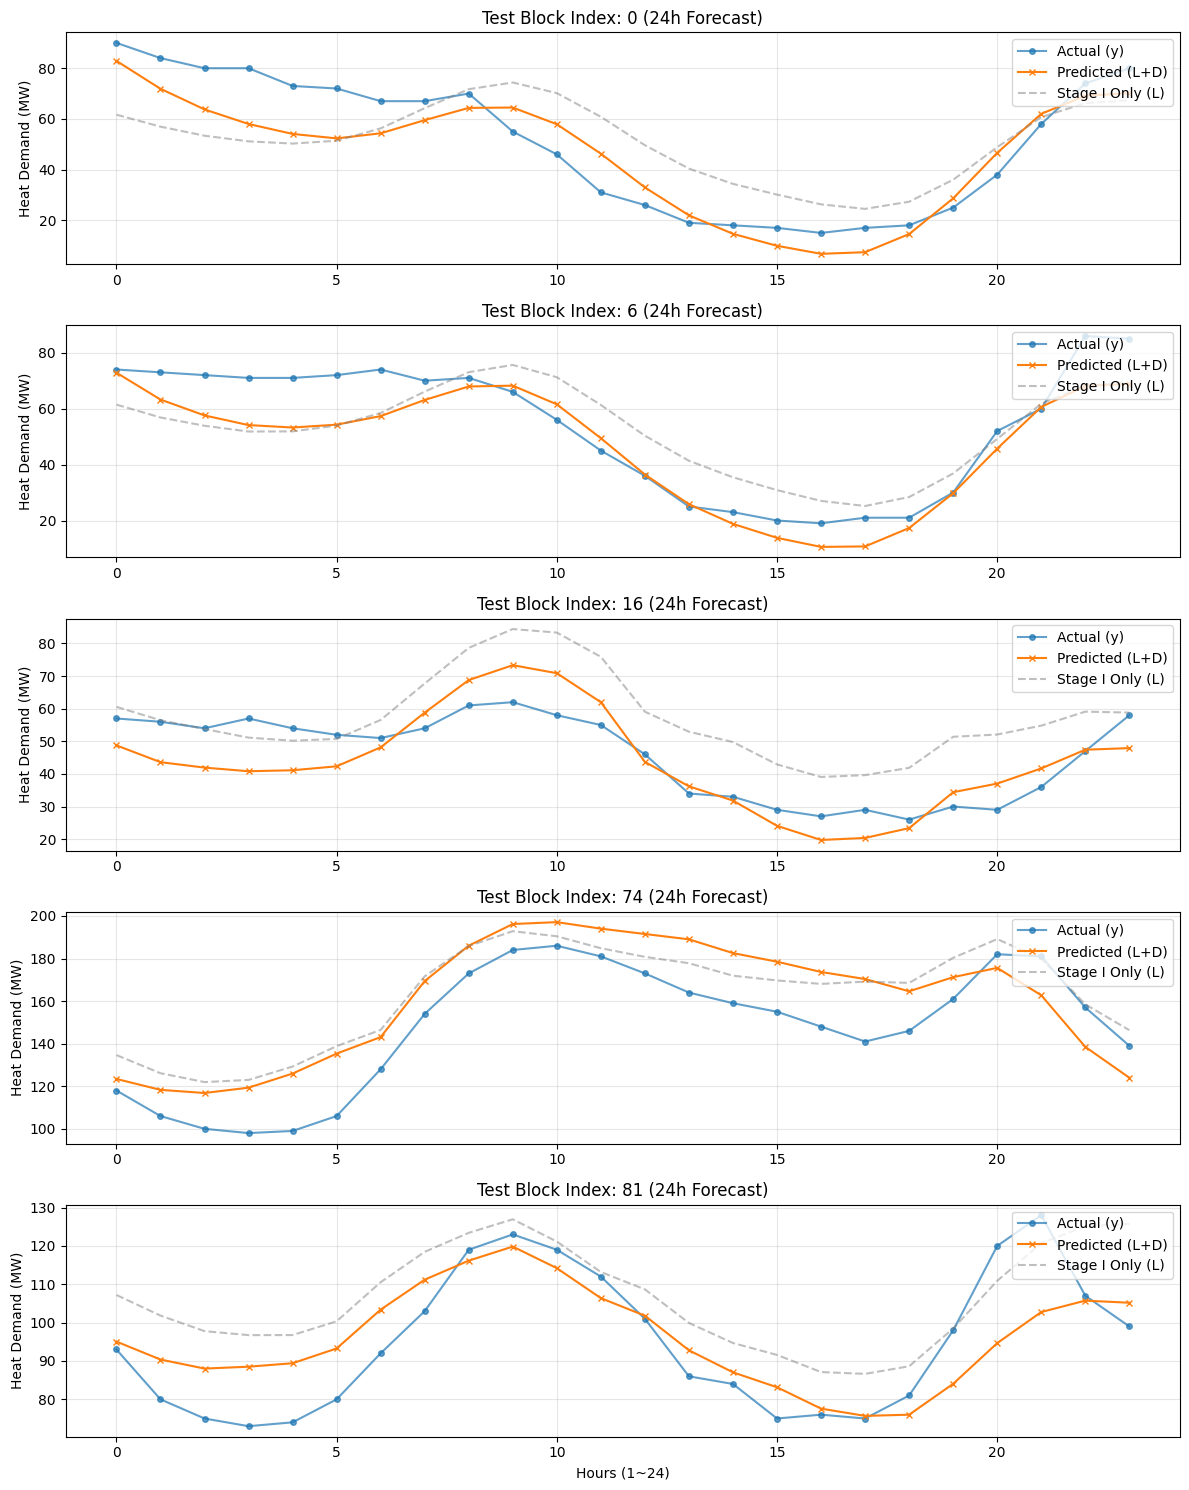

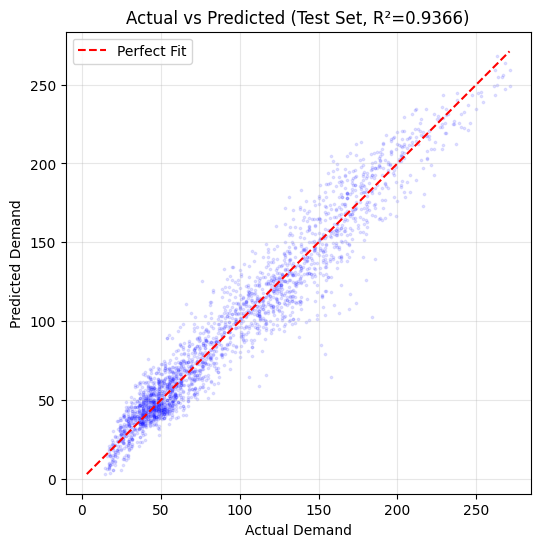

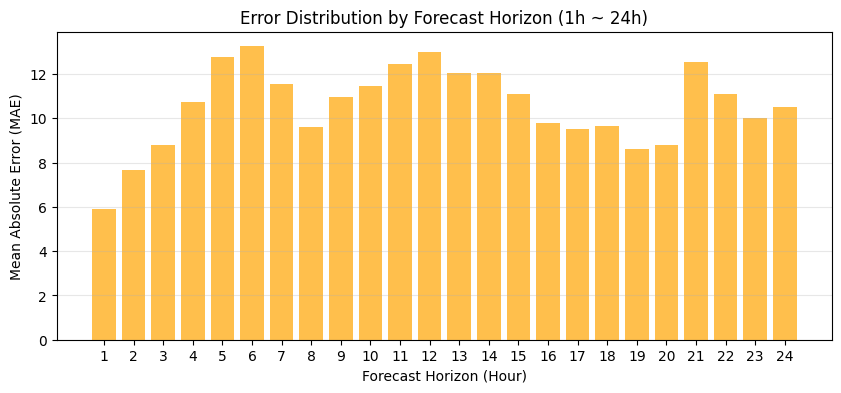

In [ ]:
test_N = len(y_all) 

idx_val_end = min(val_end, test_N) 

# Test Cutoff 생성
cut_test = make_cutoffs_for_split(test_N, LOOKBACK, HORIZON, STRIDE, start=idx_val_end, end=test_N)

print(f"Test Cutoffs: {len(cut_test)} samples")


ds_test = NonOverlapSeq2SeqDataset(
    r_all_s,      # Filtered residual (scaled)
    L_all,        # Filtered L_hat
    y_all,        # Filtered y (actual)
    cut_test,
    LOOKBACK,
    HORIZON
)

# DataLoader
bs_test = best_hp.batch_size if "best_hp" in globals() and best_hp is not None else 32
test_loader = DataLoader(ds_test, batch_size=bs_test, shuffle=False, drop_last=False)

# -------------------------------------------------------
# 2. 평가 함수 (Attention 모델 호환)
# -------------------------------------------------------
@torch.no_grad()
def evaluate_all_test(model, loader, scaler_r):
    """
    전체 test set에 대한 예측 및 평가
    """
    model.eval()
    
    all_y_true = []
    all_y_pred = []
    all_L_hat = []
    all_D_hat = [] # Predicted Residual (Unscaled)
    
    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        
        # [수정] Attention 모델 Forward (Teacher Forcing = 0.0)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0, y_tf=None)
        
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()
        
        # Inverse Scale Residual
        yhat_r = scaler_r.inverse_transform(
            yhat_r_scaled.reshape(-1, 1)
        ).reshape(yhat_r_scaled.shape).astype(np.float32)
        
        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)
        
        # 최종 예측값: 구조적 성분(L) + 잔차 예측값(D)
        yhat = L_future + yhat_r
        
        all_y_true.append(y_future)
        all_y_pred.append(yhat)
        all_L_hat.append(L_future)
        all_D_hat.append(yhat_r)
    
    return (
        np.concatenate(all_y_true, axis=0),
        np.concatenate(all_y_pred, axis=0),
        np.concatenate(all_L_hat, axis=0),
        np.concatenate(all_D_hat, axis=0),
    )

# -------------------------------------------------------
# 3. 실행 및 메트릭 계산
# -------------------------------------------------------
# 전체 test set 예측 수행
y_true_all, y_pred_all, L_all_test, D_all_test = evaluate_all_test(model_final, test_loader, scaler_r)

print(f"Test predictions shape: {y_true_all.shape}")
print(f"Total hours predicted: {y_true_all.size}")

# 1D Array로 변환하여 메트릭 계산
y_true_flat = y_true_all.flatten()
y_pred_flat = y_pred_all.flatten()

mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)

# MAPE (0으로 나누기 방지)
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100
r2 = r2_score(y_true_flat, y_pred_flat)

print(f"\n=== Test Set Performance (Stage I + II Attention) ===")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

# -------------------------------------------------------
# 4. 시각화
# -------------------------------------------------------

# 시각화 1: 시계열 블록 비교 (랜덤하게 4개 + 첫번째 1개)
idxs_to_show = [0] + sorted(np.random.choice(len(y_true_all), 4, replace=False).tolist())
n_blocks = len(idxs_to_show)

fig, axes = plt.subplots(n_blocks, 1, figsize=(12, 3 * n_blocks), sharex=False)
if n_blocks == 1: axes = [axes]

for i, idx in enumerate(idxs_to_show):
    ax = axes[i]
    ax.plot(y_true_all[idx], label="Actual (y)", marker='o', markersize=4, alpha=0.7)
    ax.plot(y_pred_all[idx], label="Predicted (L+D)", marker='x', markersize=4, linestyle='-', linewidth=1.5)
    ax.plot(L_all_test[idx], label="Stage I Only (L)", linestyle='--', alpha=0.5, color='gray')
    
    ax.set_title(f"Test Block Index: {idx} (24h Forecast)")
    ax.set_ylabel("Heat Demand (MW)")
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    if i == n_blocks - 1:
        ax.set_xlabel("Hours (1~24)")

plt.tight_layout()
plt.show()

# 시각화 2: Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat, alpha=0.1, s=3, color='blue')
# 기준선 (Perfect Prediction)
min_val = min(y_true_flat.min(), y_pred_flat.min())
max_val = max(y_true_flat.max(), y_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')

plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title(f"Actual vs Predicted (Test Set, R²={r2:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# 시각화 3: 시간대별 오차 (Forecast Horizon별 MAE)
hourly_mae = np.mean(np.abs(y_true_all - y_pred_all), axis=0)
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(hourly_mae)+1), hourly_mae, color='orange', alpha=0.7)
plt.xlabel("Forecast Horizon (Hour)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Error Distribution by Forecast Horizon (1h ~ 24h)")
plt.xticks(range(1, len(hourly_mae)+1))
plt.grid(True, axis='y', alpha=0.3)
plt.show()

In [ ]:
# 1. 모델 재정의 및 가중치 로드
model_viz = Seq2SeqLSTMAttention(
    hidden_size=best_hp.hidden_size, 
    num_layers=best_hp.num_layers, 
    dropout=best_hp.dropout
).to(device)

# 저장했던 경로에서 다시 불러오기
save_path = "/Users/zongseung/Heat-Demand/CHP-project/best_lstm_model_GLAM_Attention_section2.pth"
model_viz.load_state_dict(torch.load(save_path))
model_viz.eval()

print("Model loaded for visualization.")

# 2. Test Set에서 샘플 하나 가져오기
# (배치 하나만 뽑아서 그 중 첫 번째 데이터를 봅니다)
x_sample, y_r_sample, _, _ = next(iter(test_loader))
x_sample = x_sample.to(device)

# 3. 예측 및 어텐션 가중치 추출 (return_attention=True)
with torch.no_grad():
    y_pred, attn_weights = model_viz(x_sample, horizon=24, return_attention=True)

# GPU -> CPU 변환
attn_weights = attn_weights.cpu().numpy() # Shape: (Batch, Horizon, Lookback)

print(f"Attention Weights Shape: {attn_weights.shape}") 
# 예: (32, 24, 168) -> (배치크기, 예측시간, 과거참조시간)

Model loaded for visualization.
Attention Weights Shape: (32, 24, 168)


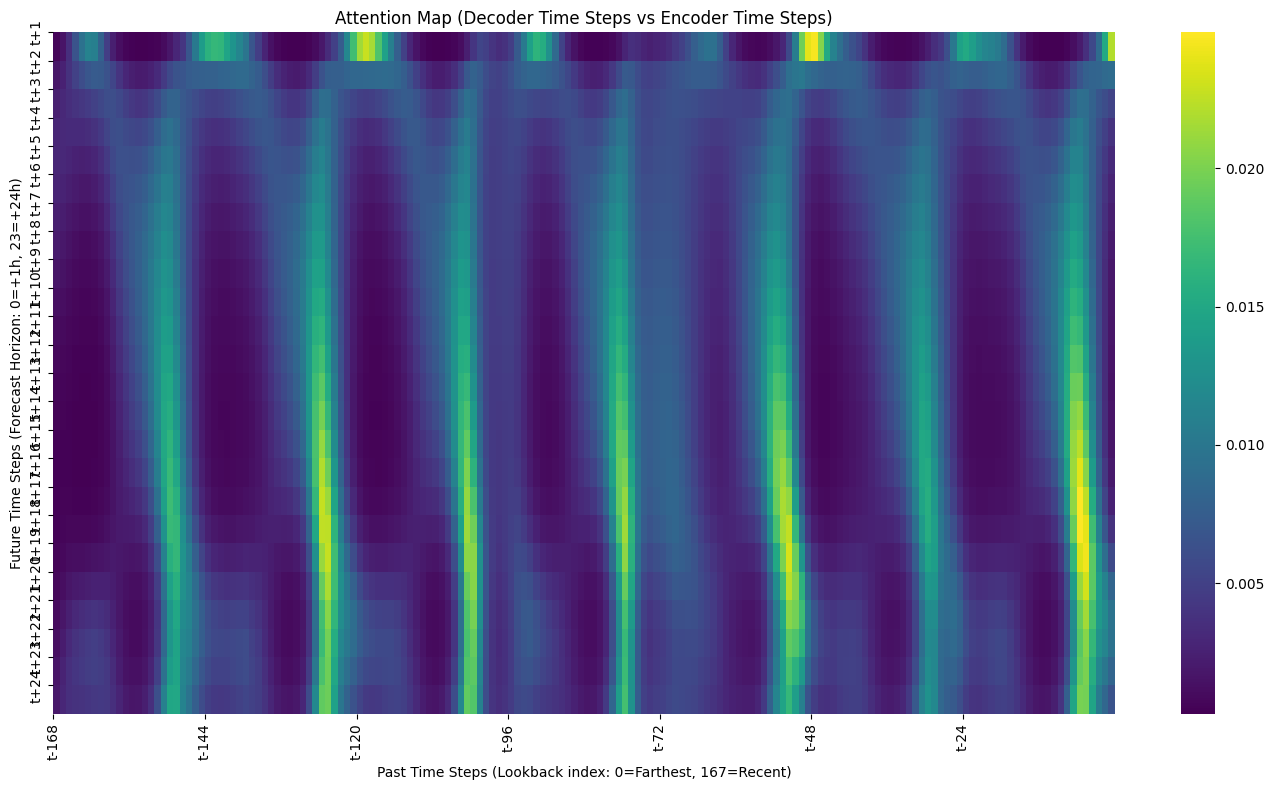

In [ ]:
import seaborn as sns

# 볼 샘플 인덱스 (배치 내에서 0번째 데이터)
sample_idx = 0 
map_data = attn_weights[sample_idx] # (24, 168)

plt.figure(figsize=(14, 8))

# 히트맵 그리기
# cmap='viridis'나 'Blues', 'Reds' 등을 추천
sns.heatmap(map_data, cmap='viridis', cbar=True)

plt.title("Attention Map (Decoder Time Steps vs Encoder Time Steps)")
plt.xlabel("Past Time Steps (Lookback index: 0=Farthest, 167=Recent)")
plt.ylabel("Future Time Steps (Forecast Horizon: 0=+1h, 23=+24h)")

# 축 눈금 좀 더 보기 좋게 설정
plt.xticks(np.arange(0, 168, 24), labels=[f"t-{168-i}" for i in range(0, 168, 24)])
plt.yticks(np.arange(0, 24, 1), labels=[f"t+{i+1}" for i in range(24)])

plt.tight_layout()
plt.show()